In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
import shutil, sys                                                                                                                                                    
from collections import Counter

import re
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from nltk import pos_tag, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary,alpha="auto",eval_every=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

def applyVader(data):
    vader = SentimentIntensityAnalyzer()
    text = data["text"].tolist()
    scores = list()
    positive = list()
    negative = list()
    neut = list()
    for t in text:
        scores.append(vader.polarity_scores(t)['compound'])
        positive.append(vader.polarity_scores(t)['pos'])
        negative.append(vader.polarity_scores(t)['neg'])
        neut.append(vader.polarity_scores(t)['neu'])
    data["vaderScore"] = scores
    data = data[data["is_retweet"] == False]
    data["vaderScoreBinned"] = pd.cut(data["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
    data.rename(index=str, columns={"year": "date_year"},inplace=True)
    data.rename(index=str, columns={"month": "date_month"},inplace=True)
    data.drop(["date_month","hour","in_reply_to_user_id_str","is_retweet","modded_text","modded1","date","week_year"],axis=1,inplace=True)
    data.corr()
    return data

def applyVader1(data):
    vader = SentimentIntensityAnalyzer()
    text = data["text"].tolist()
    scores = list()
    positive = list()
    negative = list()
    neut = list()
    for t in text:
        scores.append(vader.polarity_scores(t)['compound'])
        positive.append(vader.polarity_scores(t)['pos'])
        negative.append(vader.polarity_scores(t)['neg'])
        neut.append(vader.polarity_scores(t)['neu'])
    data["vaderScore"] = scores
    data["vaderScoreBinned"] = pd.cut(data["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
    data.rename(index=str, columns={"year": "date_year"},inplace=True)
    data.rename(index=str, columns={"month": "date_month"},inplace=True)
    data.drop(['Unnamed: 0','week_year', 'date_month',
       'modded_text', 'modded1','modded1_stemmed'],axis=1,inplace=True)
    data.corr()
    return data

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/menis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/menis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/menis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def processAndFindTopics(data):
    stop = stopwords.words('english')
    data['temp'] = data['noTags_punct'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    words = pd.Series(' '.join(data['temp']).split()).value_counts()
    print(len(words))
    plt.title("pre word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    words = words[5:]
    words = words[words > 2]
    plt.title("post word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    data['temp'] = data['temp'].apply(lambda x: " ".join(x for x in x.split() if x in words))
    tokenizer = RegexpTokenizer(r'\w+')

    #corpus = d1["m"].tolist()
    corpus = data["temp"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(str(string))
        corp.append(tokens)

    common_dictionary = Dictionary(corp)
    common_corpus = [common_dictionary.doc2bow(text) for text in corp]
    #tfidf = TfidfModel(common_corpus)
    #tfidf_corpus = tfidf[common_corpus]
    start,stop,step=3,20,1
    nTopics = plot_graph(corp,start,stop,step,common_corpus,common_dictionary) #usare tfidf mi pare di aver capito sia inutile
                         #tfidf_corpus,common_dictionary)

    print(nTopics)
    return nTopics, common_dictionary, common_corpus

def procAndTopicsTagged(data):
    stop = stopwords.words('english')
    data['temp'] = data['noTags_punct'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    words = pd.Series(' '.join(data['temp']).split()).value_counts()
    print(len(words))
    plt.title("pre word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    words = words[5:]
    words = words[words > 2]
    plt.title("post word distribution")
    plt.hist(words.values,bins=70,log=True)
    plt.show()
    data['temp'] = data['temp'].apply(lambda x: " ".join(x for x in x.split() if x in words))
    tokenizer = RegexpTokenizer(r'\w+')

    taggedDescriptions = []
    for idx, row in data.iterrows():
        desc = row["noTags_punct"]
        tokens = word_tokenize(desc)
        tagged = pos_tag(tokens)
        taggedDescriptions.append(tagged)
        
    descriptions = []
    for item in taggedDescriptions:
        processed = ""
        for el in item:
            if el[1].startswith("N"): #or el[1].startswith("J"):  #se iniziano con N o J sono nomi o aggettivi, quello che ci serve di più
                processed = processed + " " + el[0]
        descriptions.append(processed)

    data["n_j"] = descriptions
    
    corpus = data["n_j"].tolist()
    #print(len(corpus))
    corp = []
    for string in corpus:
        tokens = tokenizer.tokenize(str(string))
        corp.append(tokens)
    common_dictionary = Dictionary(corp)
    common_corpus = [common_dictionary.doc2bow(text) for text in corp]
    #tfidf = TfidfModel(common_corpus)
    #tfidf_corpus = tfidf[common_corpus]
    start,stop,step=3,20,1
    nTopics = plot_graph(corp,start,stop,step,common_corpus,common_dictionary) #usare tfidf mi pare di aver capito sia inutile
                         #tfidf_corpus,common_dictionary)
    print(nTopics)
    return nTopics, common_dictionary, common_corpus


In [3]:
def applyLda(data,nTopics,corpus,common_dictionary):
    lda = LdaModel(corpus, num_topics=nTopics, id2word=common_dictionary,alpha="auto",eval_every=2)
    topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False)
    #print(g)
    topicList = {}
    topicColumn = []
    for el in corpus:
        vector = lda.get_document_topics(el)
        #get topic
        m = max(y for (x,y) in vector)
        ind = [x for x, y in enumerate(vector) if y[1] == m][0]
        #print(ind,m)
        if ind not in topicList:
            topicList[ind] = 1
        else: 
            topicList[ind] += 1
        topicColumn.append(ind)

    print(len(topicColumn),len(data))
    data["topic"] = topicColumn
    #print(topicColumn)
    plt.figure()
    plt.title("Topic frequency")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    data["topic"].value_counts().plot(kind="bar")


    data.sort_values(["topic"],inplace=True)
    return topics

def analyzeRes(data,topics,mode):
    for t in data["topic"].unique():
        print(t)
        g1 = data[data["topic"] ==t]
        print("NUMBER OF ELEMENTS FOR THIS TOPIC "+ str(len(g1)))
        #ax = plt.subplot(121)
        #g1.vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        #plt.title("Vader score topic " + str(t))
        #plt.xlabel("Vader score")
        words = []
        weights = []
        for word in topics[t][1]:
            if abs(word[1]) > 0.001:
                words.append(word[0])
                #prendi valore assoluto perchè positivo/negativo non ha senso 
                weights.append(abs(word[1]))
        labels = words
        sizes = weights
                
        sentences = g1["temp"].tolist()
        fullText = " ".join(sentences)
        text_in_words = [w for w in fullText.split(' ') if w.strip() != '' or w == '\n']
        print('Corpus length in words:', len(text_in_words))
        word_freq = dict(Counter(fullText.split()))
        word_freq = sorted(word_freq.items(), key=lambda pair: pair[1], reverse=True)[0:10]
        weightsFreq = [x for (y,x) in word_freq]
        wordsFreq = [y for (y,x) in word_freq]

        if mode == 0:
            plt.figure(figsize=(14,5))
            
            g1["vaderScoreBinned"] = pd.cut(g1["vaderScore"], [-1,-0.05,0.05,1], labels=["negative", "neutral", "positive"])
            g2 = g1.groupby(["vaderScoreBinned"])["vaderScoreBinned"].count()
            ax = plt.subplot(121)
            plt.title("Binned VADER scores")
            plt.ylabel("Number of tweets")
            plt.xlabel("Bins")
            plt.bar(g2.index, g2,label=["Negative","Neutral","Positive"] )
            #plt.show()

            plt.subplot(122)
            plt.title("Topic " + str(t))
            sns.barplot(x=weights, y=words)
            plt.xlabel("Topic contribution")
            plt.ylabel("Word")
            plt.subplots_adjust(wspace=0.35)
            plt.show()     
            

            fig = plt.figure()
            plt.title("frequenze")
            sns.barplot(x=weightsFreq, y=wordsFreq,figure=fig)
            plt.xlabel("Frequency",figure=fig)
            plt.ylabel("Word",figure=fig)
            plt.show()
            
        elif mode == 1:
            plt.figure(figsize=(14,5))
            
            ax = plt.subplot(121)
            plt.title("Topic " + str(t))
            sns.barplot(x=weights, y=words)
            plt.xlabel("Topic contribution")
            plt.ylabel("Word")
            plt.subplots_adjust(wspace=0.35)
            
            plt.subplot(122)
            g1.vaderScore.plot(kind = 'hist',bins=[-1,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,
                                                   0.5,0.6,0.7,0.8,0.9,1])
            plt.title("Vader score for topic " + str(t))
            plt.xlabel("Vader score")
            plt.show()

        '''hashtags = []
        for idx,row in g1.iterrows():
            l = re.findall("#\S+",row["text"])
            for tag in l:
                hashtags.append(tag)
        hashtags = pd.Series(hashtags).value_counts()
        print(hashtags[:10])'''
        

In [4]:
data = pd.read_json("preprocessingDoneRight.json")

In [12]:
def process(data,label):
    temp = applyVader(data)
    temp = temp[temp["vaderScoreBinned"] == label]
    
    nTopics, common_dict, corpus = processAndFindTopics(temp)
    topics = applyLda(temp,nTopics,corpus,common_dict)
    analyzeRes(temp,topics,1)

def process1(data,label):
    temp = applyVader1(data)
    temp = temp[temp["vaderScoreBinned"] == label]
    
    nTopics, common_dict, corpus = processAndFindTopics(temp)
    topics = applyLda(temp,nTopics,corpus,common_dict)
    analyzeRes(temp,topics,1)

plt.title("Tweet frequency by VADER score")
plt.ylabel("Frequency")
pre["vaderScoreBinned"].value_counts().plot(kind="bar")

# PRE ELECTION

In [6]:
pre = data[data["year"] < 2016]
pre = data[data["year"] > 2009]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


14525


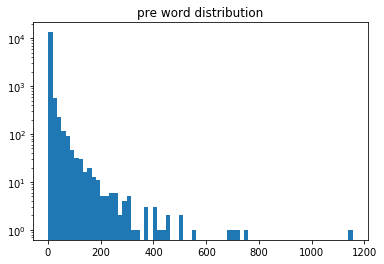

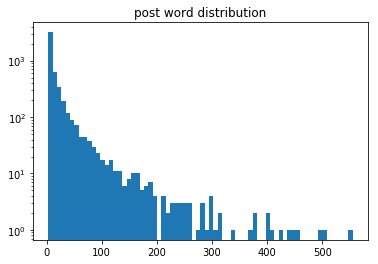

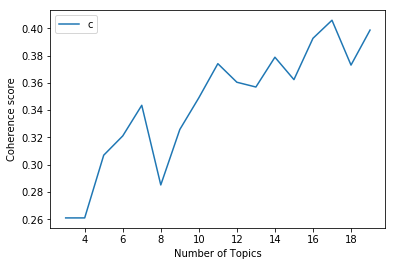

17
8802 8802
0
NUMBER OF ELEMENTS FOR THIS TOPIC 2795
Corpus length in words: 30230


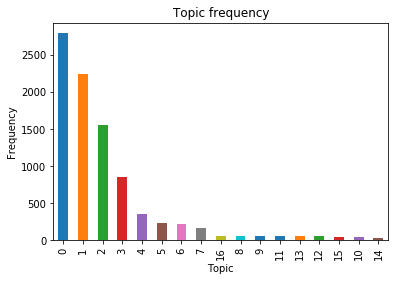

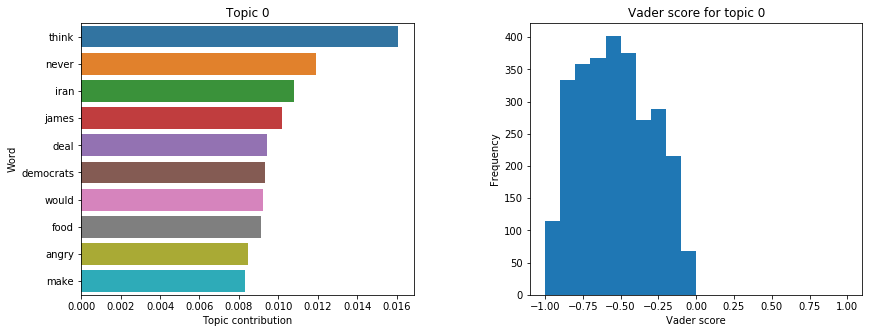

1
NUMBER OF ELEMENTS FOR THIS TOPIC 2238
Corpus length in words: 24885


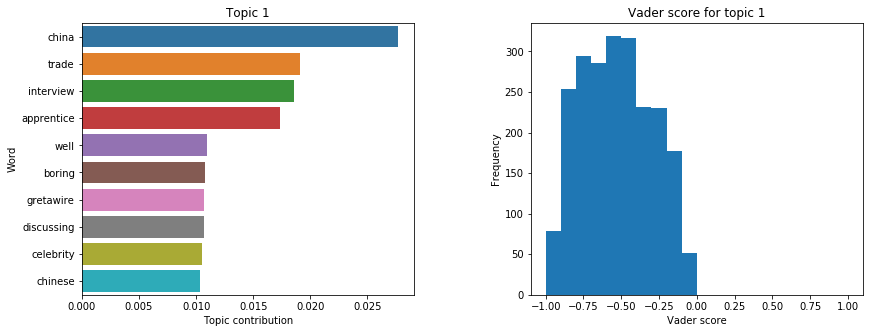

2
NUMBER OF ELEMENTS FOR THIS TOPIC 1554
Corpus length in words: 17966


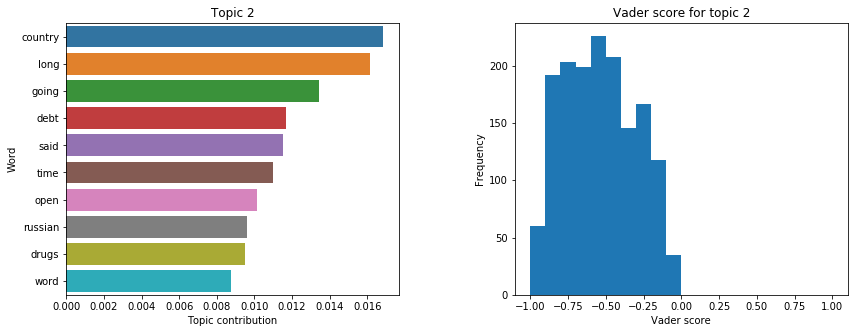

3
NUMBER OF ELEMENTS FOR THIS TOPIC 855
Corpus length in words: 10943


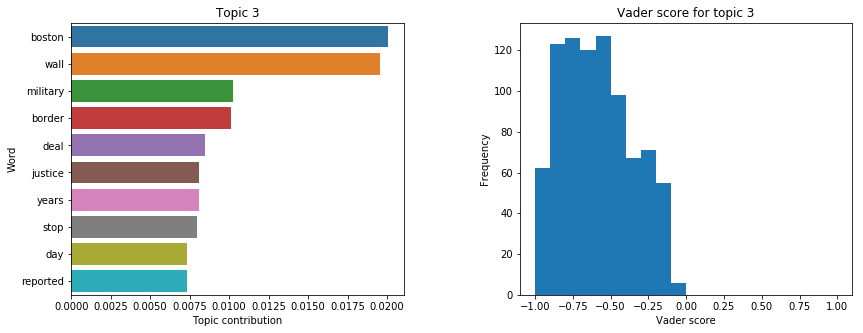

4
NUMBER OF ELEMENTS FOR THIS TOPIC 346
Corpus length in words: 4596


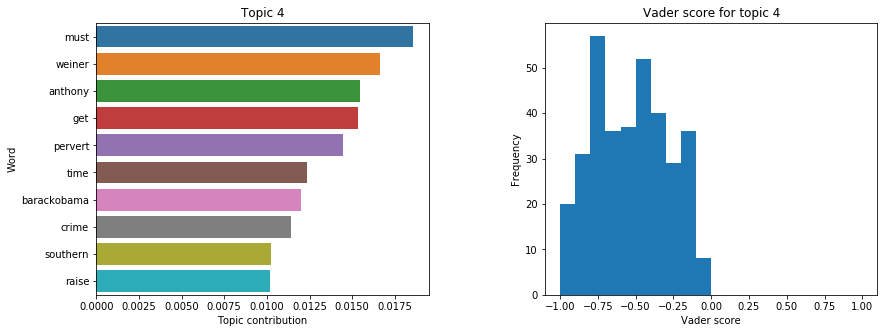

5
NUMBER OF ELEMENTS FOR THIS TOPIC 231
Corpus length in words: 3078


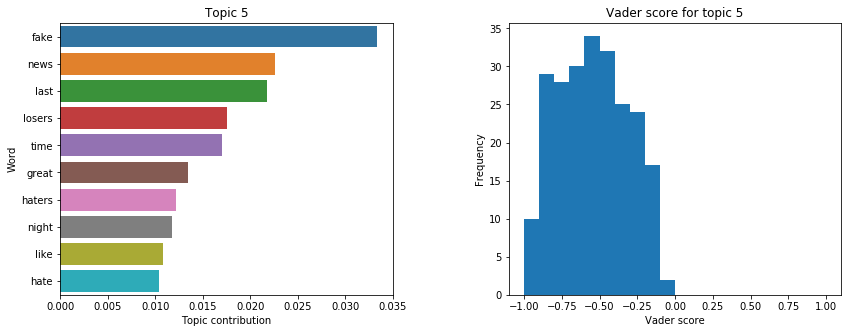

6
NUMBER OF ELEMENTS FOR THIS TOPIC 211
Corpus length in words: 1593


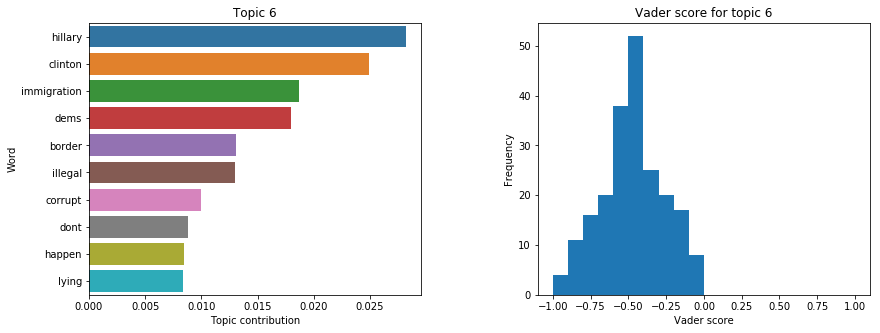

7
NUMBER OF ELEMENTS FOR THIS TOPIC 159
Corpus length in words: 986


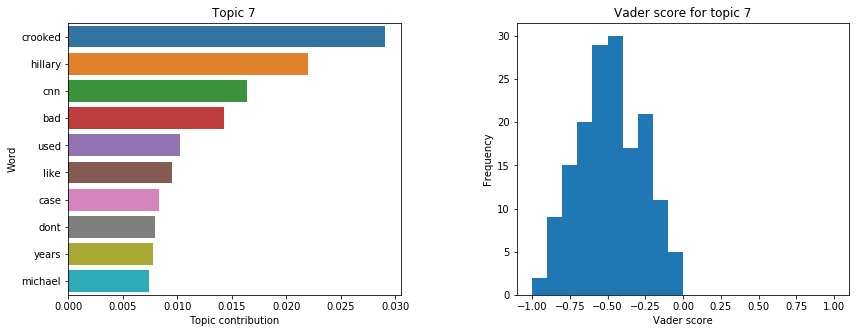

8
NUMBER OF ELEMENTS FOR THIS TOPIC 52
Corpus length in words: 268


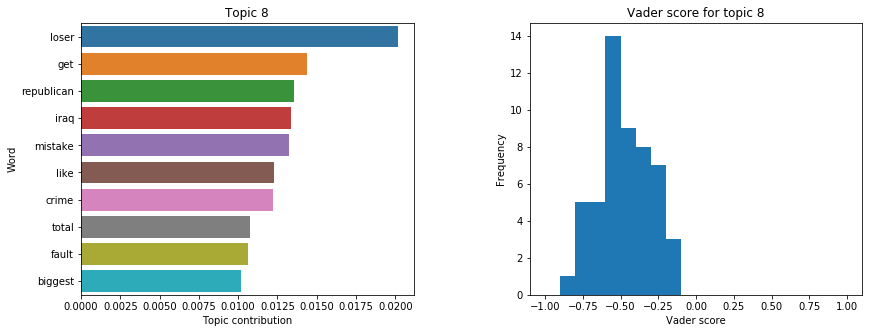

9
NUMBER OF ELEMENTS FOR THIS TOPIC 51
Corpus length in words: 202


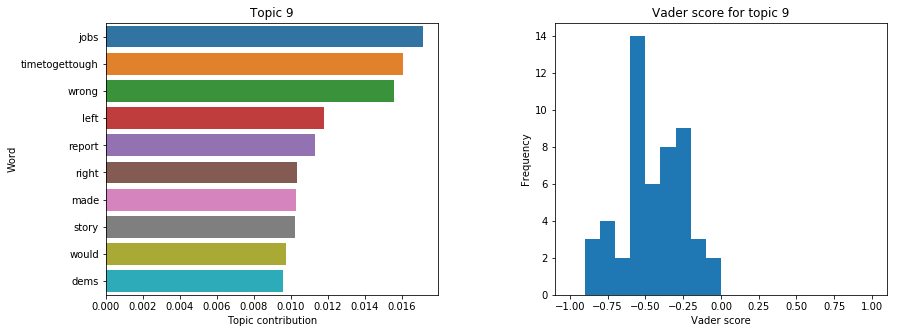

10
NUMBER OF ELEMENTS FOR THIS TOPIC 35
Corpus length in words: 125


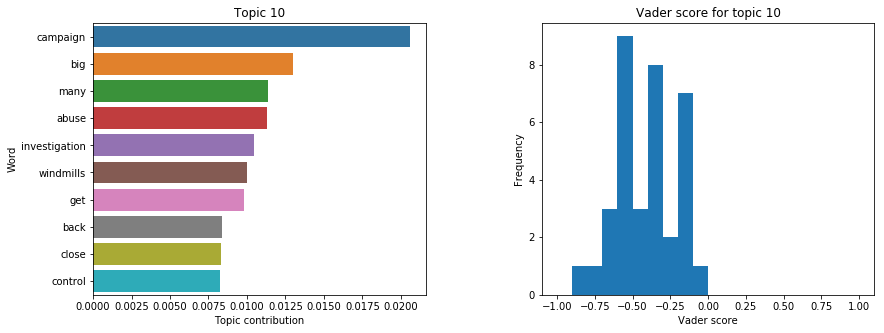

11
NUMBER OF ELEMENTS FOR THIS TOPIC 49
Corpus length in words: 166


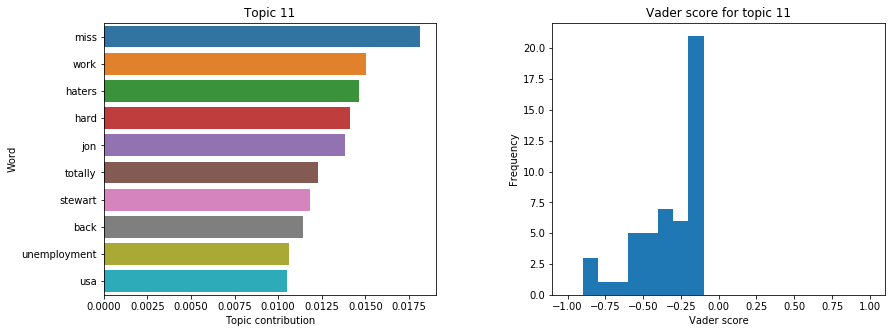

12
NUMBER OF ELEMENTS FOR THIS TOPIC 48
Corpus length in words: 196


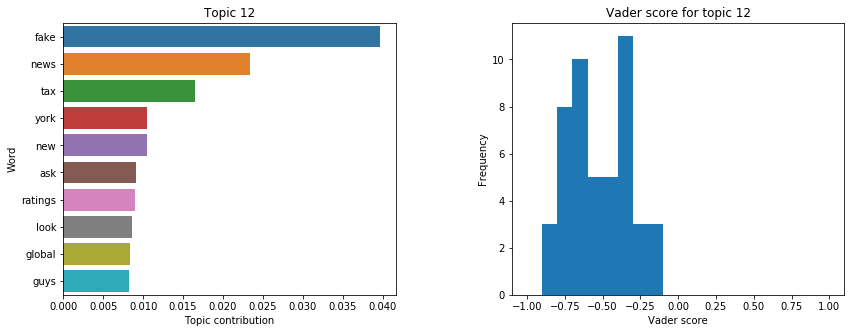

13
NUMBER OF ELEMENTS FOR THIS TOPIC 49
Corpus length in words: 220


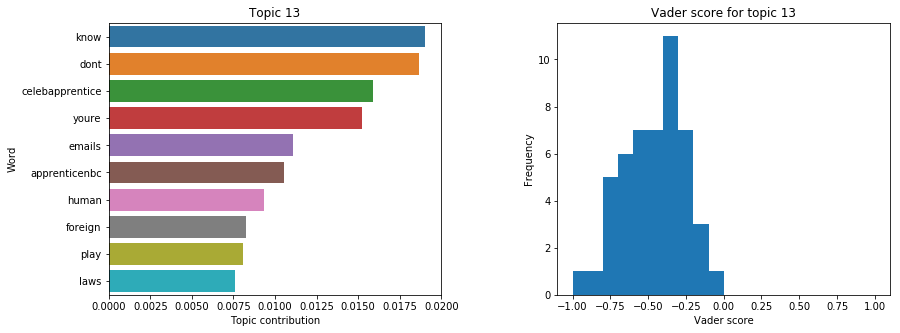

14
NUMBER OF ELEMENTS FOR THIS TOPIC 30
Corpus length in words: 120


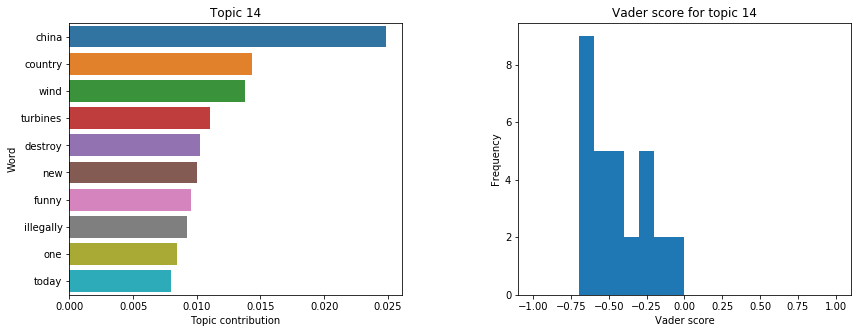

15
NUMBER OF ELEMENTS FOR THIS TOPIC 42
Corpus length in words: 168


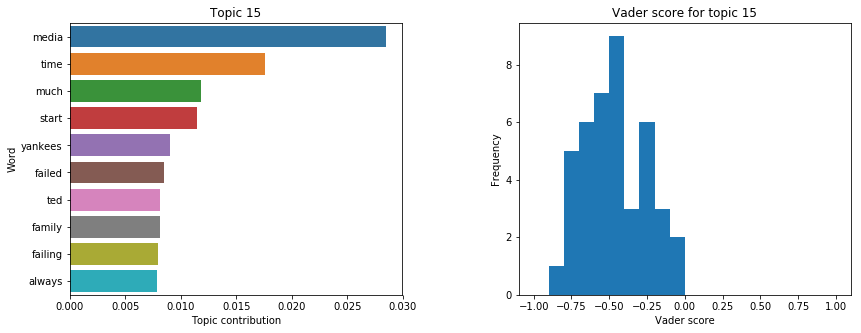

16
NUMBER OF ELEMENTS FOR THIS TOPIC 57
Corpus length in words: 208


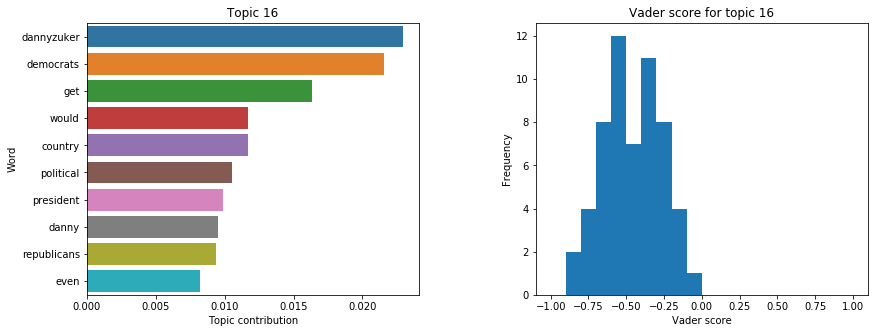

In [7]:
process(pre,"negative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


11044


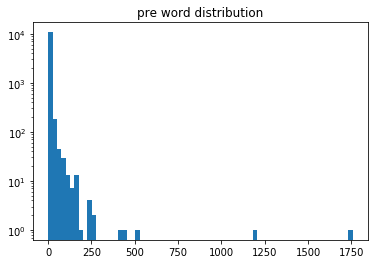

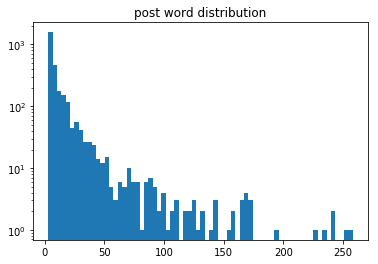

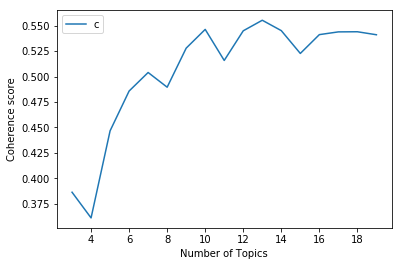

13
6223 6223
0
NUMBER OF ELEMENTS FOR THIS TOPIC 1037
Corpus length in words: 8400


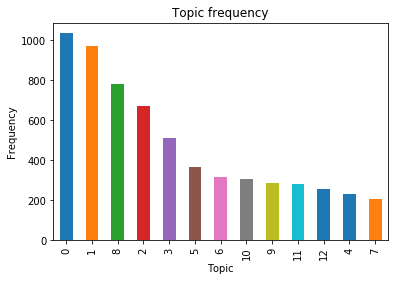

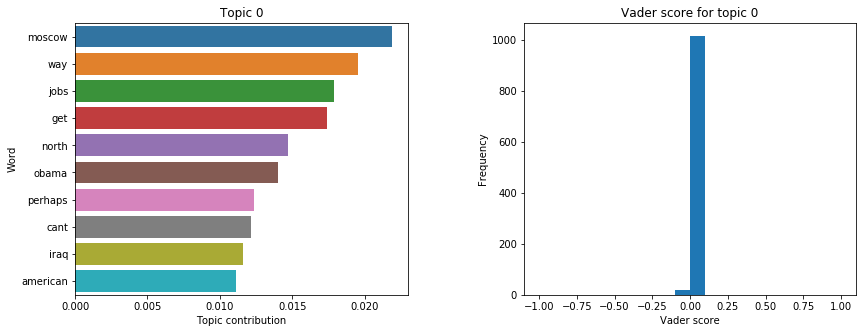

1
NUMBER OF ELEMENTS FOR THIS TOPIC 973
Corpus length in words: 7491


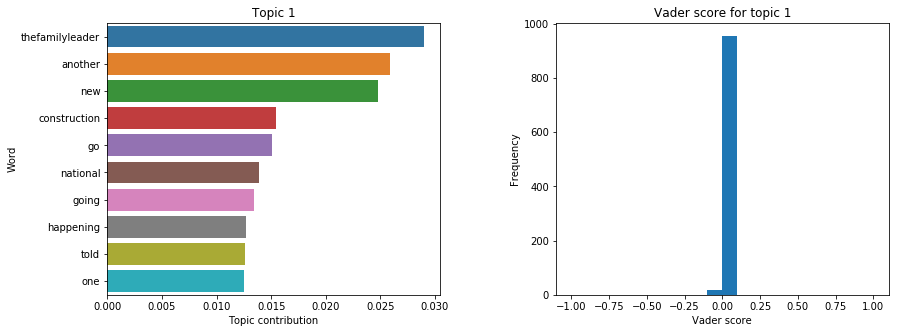

2
NUMBER OF ELEMENTS FOR THIS TOPIC 670
Corpus length in words: 5218


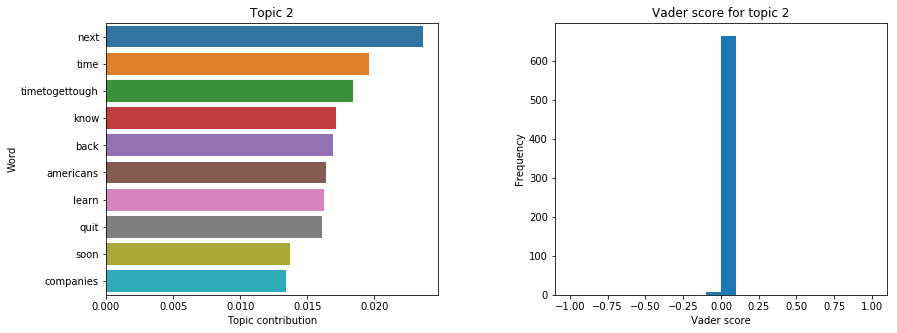

3
NUMBER OF ELEMENTS FOR THIS TOPIC 513
Corpus length in words: 3442


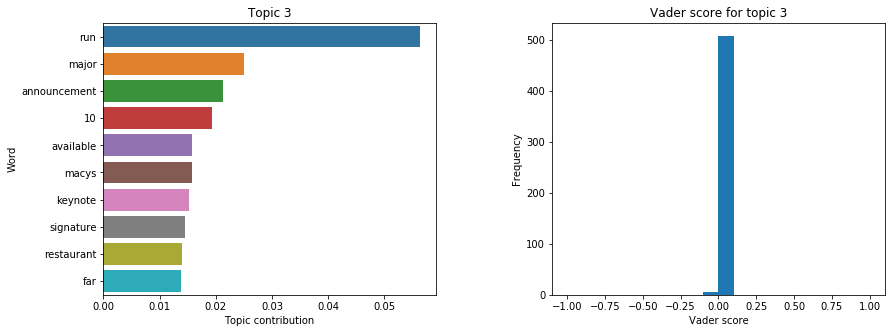

4
NUMBER OF ELEMENTS FOR THIS TOPIC 231
Corpus length in words: 1561


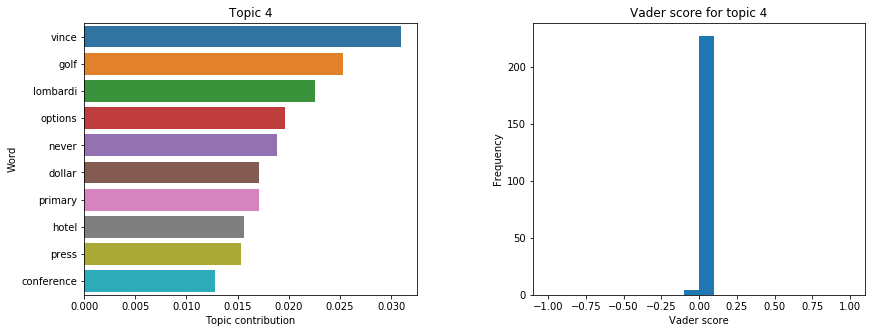

5
NUMBER OF ELEMENTS FOR THIS TOPIC 367
Corpus length in words: 1674


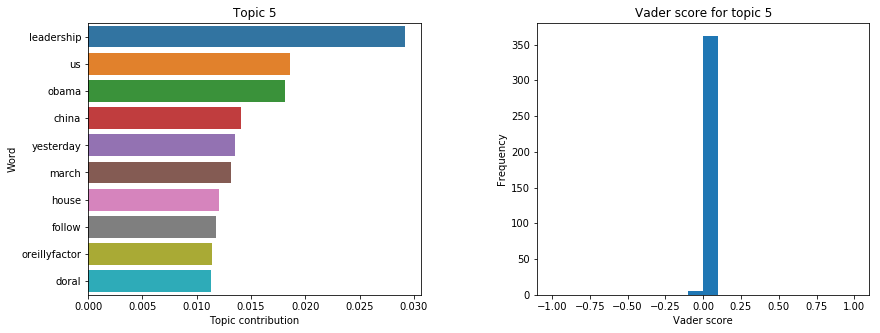

6
NUMBER OF ELEMENTS FOR THIS TOPIC 315
Corpus length in words: 1378


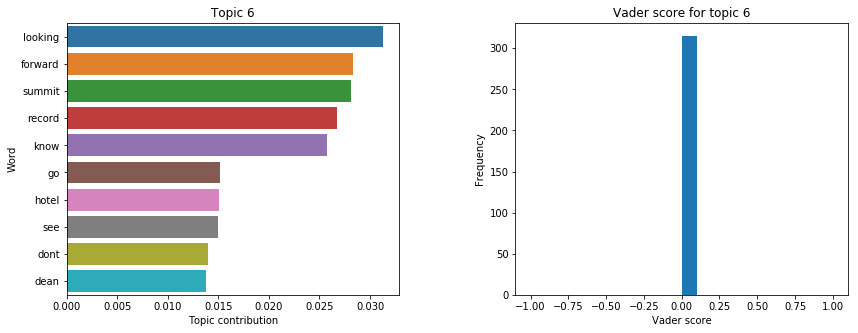

7
NUMBER OF ELEMENTS FOR THIS TOPIC 208
Corpus length in words: 951


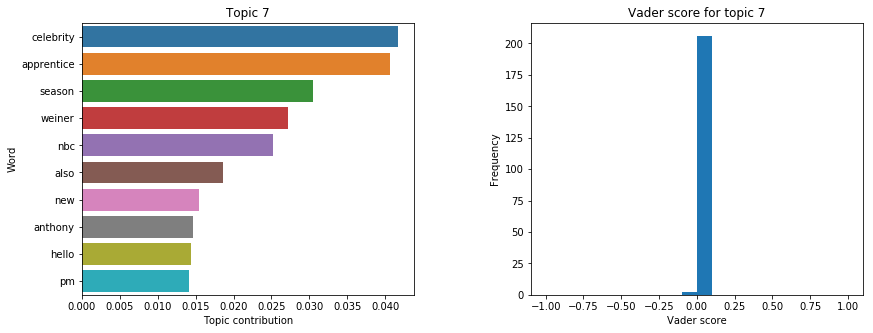

8
NUMBER OF ELEMENTS FOR THIS TOPIC 779
Corpus length in words: 2122


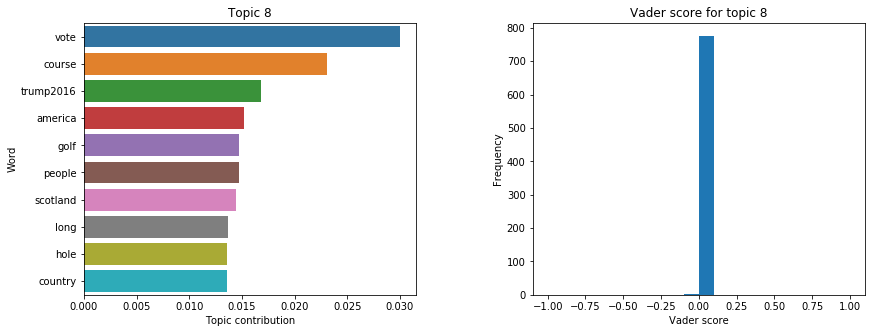

9
NUMBER OF ELEMENTS FOR THIS TOPIC 285
Corpus length in words: 1265


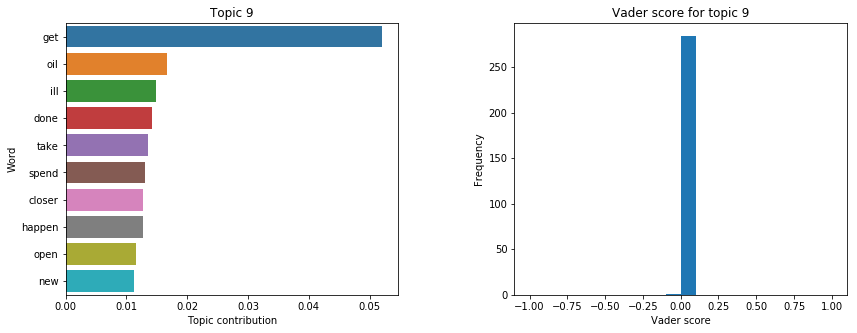

10
NUMBER OF ELEMENTS FOR THIS TOPIC 306
Corpus length in words: 1168


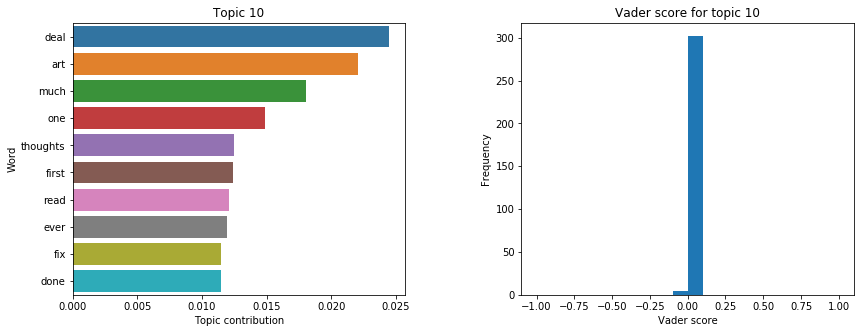

11
NUMBER OF ELEMENTS FOR THIS TOPIC 283
Corpus length in words: 1146


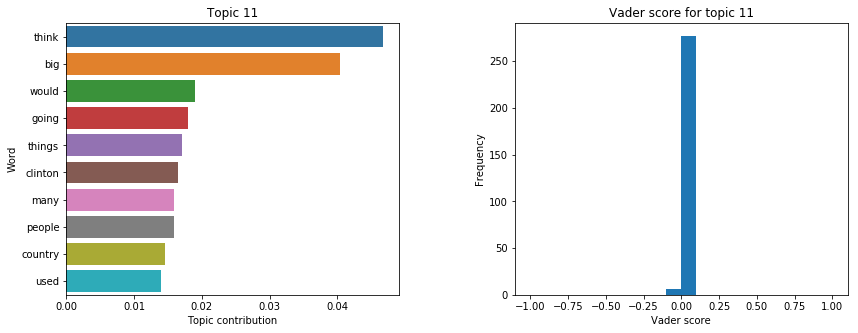

12
NUMBER OF ELEMENTS FOR THIS TOPIC 256
Corpus length in words: 996


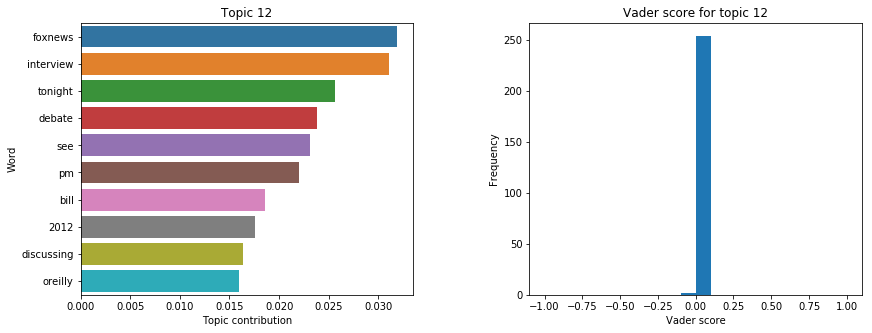

In [8]:
process(pre,"neutral")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


24161


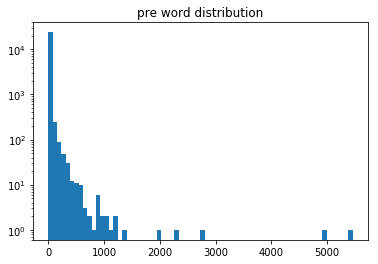

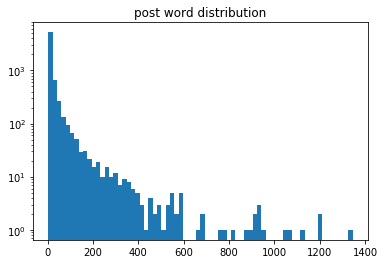

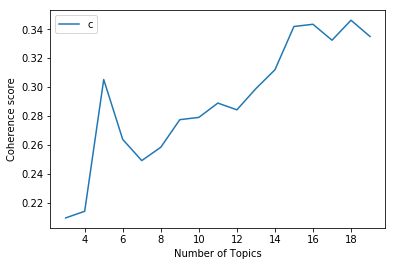

18
21078 21078
0
NUMBER OF ELEMENTS FOR THIS TOPIC 4001
Corpus length in words: 38071


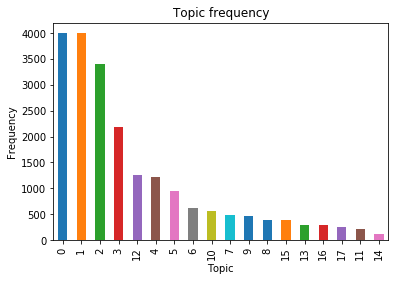

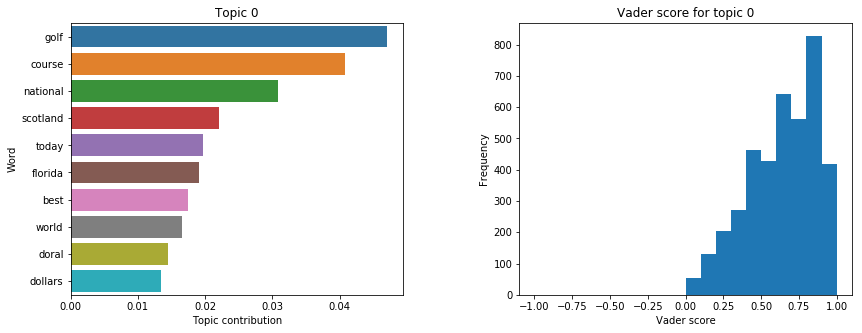

1
NUMBER OF ELEMENTS FOR THIS TOPIC 4001
Corpus length in words: 38917


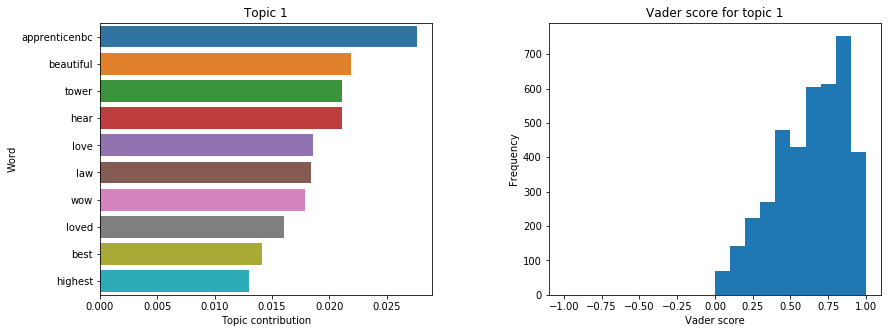

2
NUMBER OF ELEMENTS FOR THIS TOPIC 3405
Corpus length in words: 34768


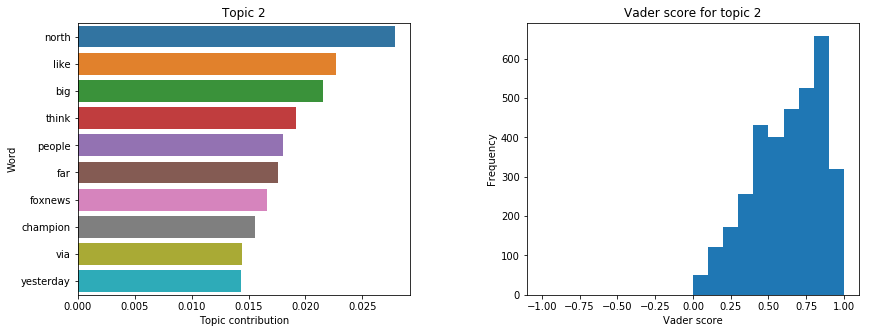

3
NUMBER OF ELEMENTS FOR THIS TOPIC 2178
Corpus length in words: 24114


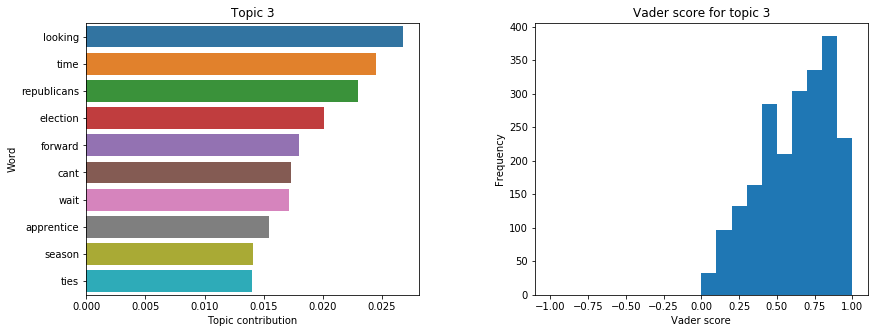

4
NUMBER OF ELEMENTS FOR THIS TOPIC 1221
Corpus length in words: 14549


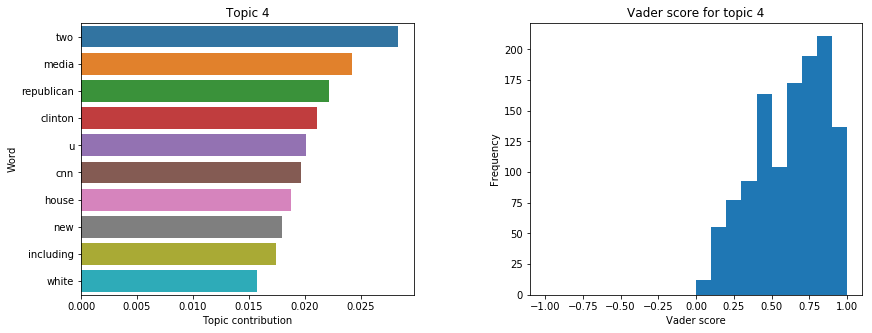

5
NUMBER OF ELEMENTS FOR THIS TOPIC 940
Corpus length in words: 8913


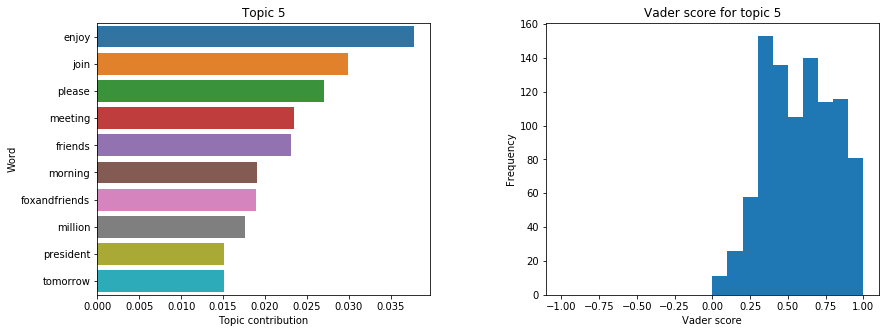

6
NUMBER OF ELEMENTS FOR THIS TOPIC 621
Corpus length in words: 5884


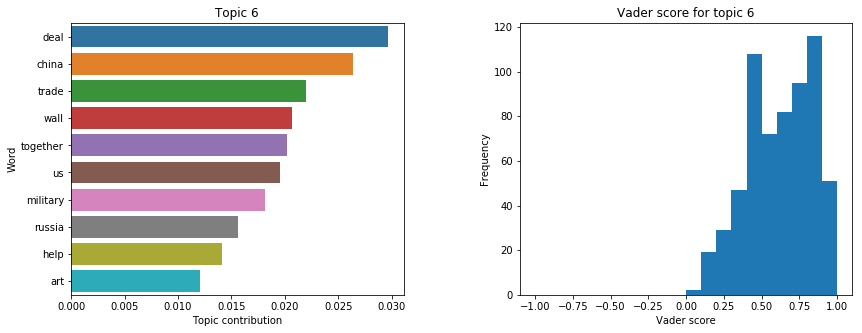

7
NUMBER OF ELEMENTS FOR THIS TOPIC 479
Corpus length in words: 3309


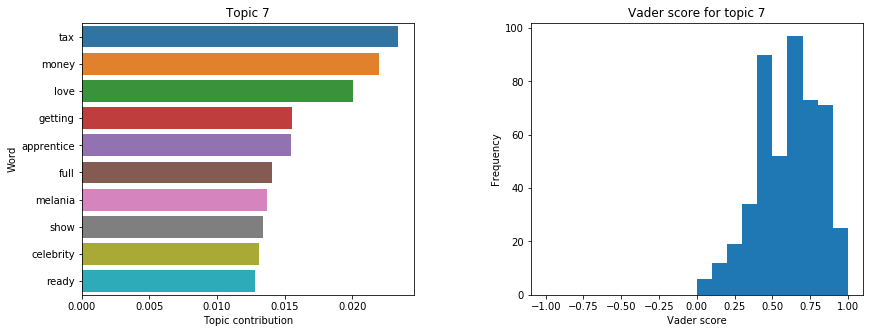

8
NUMBER OF ELEMENTS FOR THIS TOPIC 390
Corpus length in words: 2498


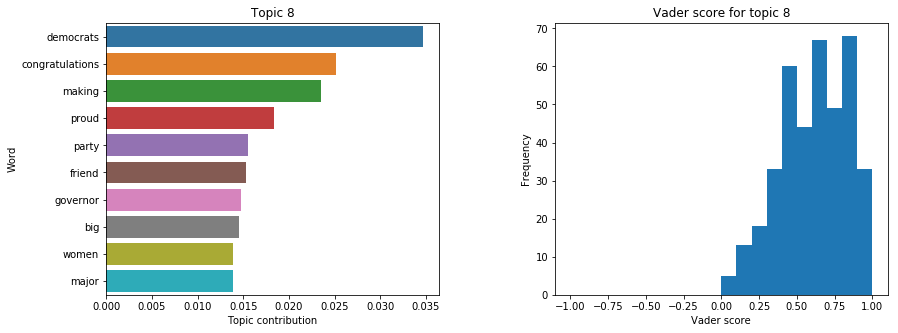

9
NUMBER OF ELEMENTS FOR THIS TOPIC 473
Corpus length in words: 2676


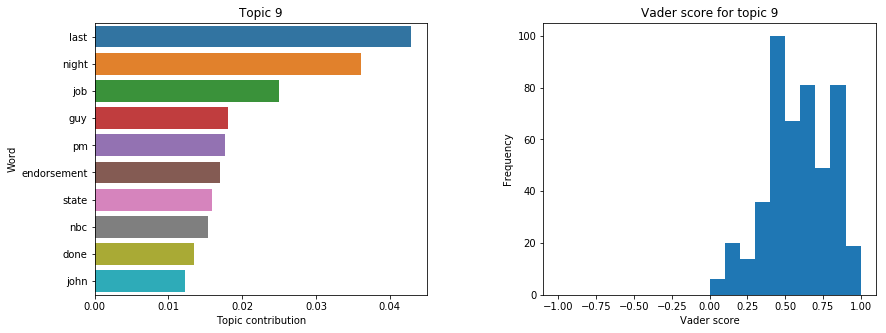

10
NUMBER OF ELEMENTS FOR THIS TOPIC 558
Corpus length in words: 2445


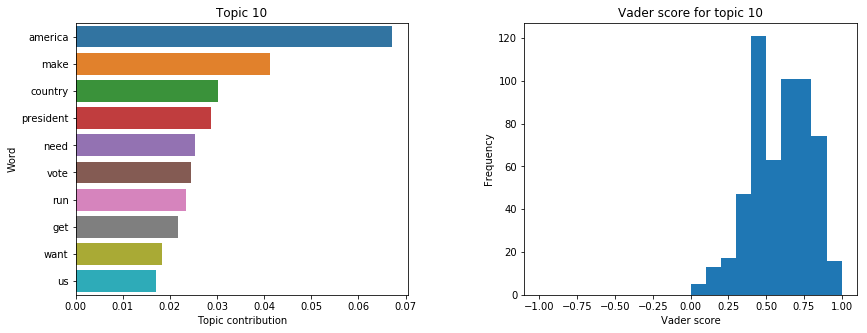

11
NUMBER OF ELEMENTS FOR THIS TOPIC 213
Corpus length in words: 840


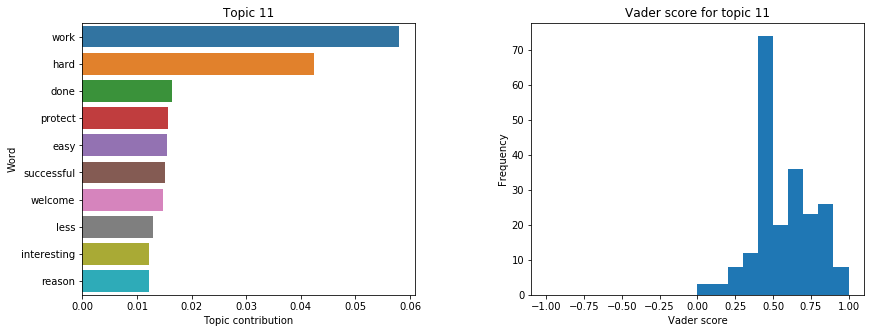

12
NUMBER OF ELEMENTS FOR THIS TOPIC 1262
Corpus length in words: 1644


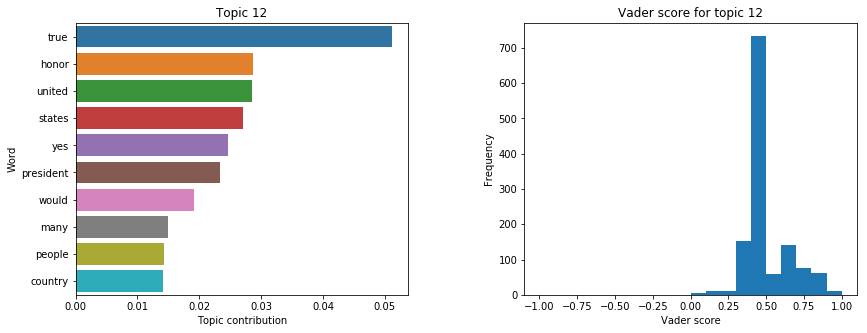

13
NUMBER OF ELEMENTS FOR THIS TOPIC 299
Corpus length in words: 1045


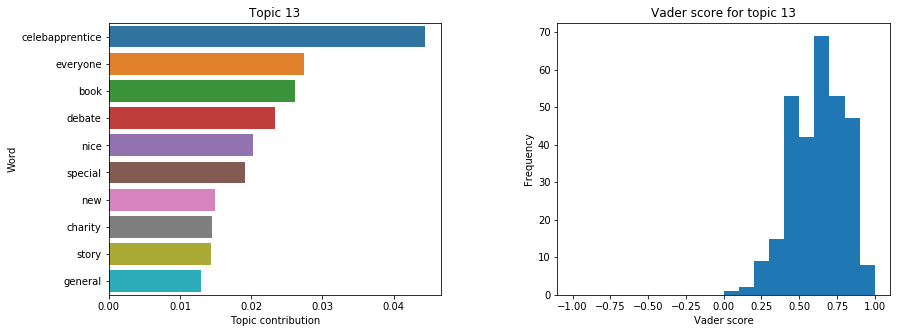

14
NUMBER OF ELEMENTS FOR THIS TOPIC 124
Corpus length in words: 540


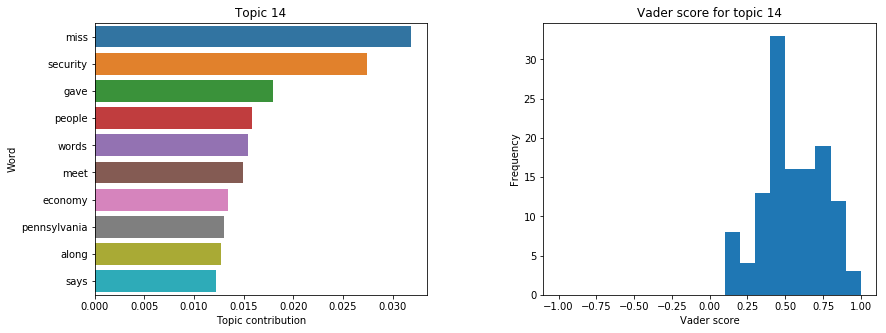

15
NUMBER OF ELEMENTS FOR THIS TOPIC 379
Corpus length in words: 1269


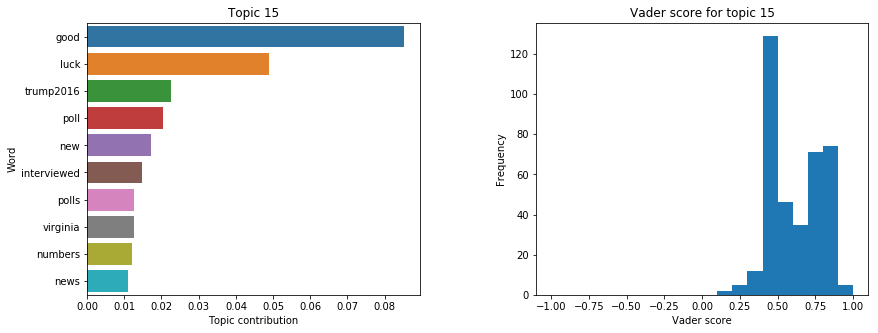

16
NUMBER OF ELEMENTS FOR THIS TOPIC 287
Corpus length in words: 1029


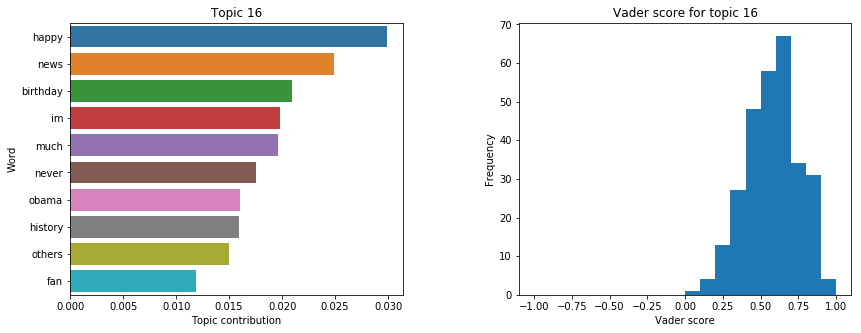

17
NUMBER OF ELEMENTS FOR THIS TOPIC 247
Corpus length in words: 1017


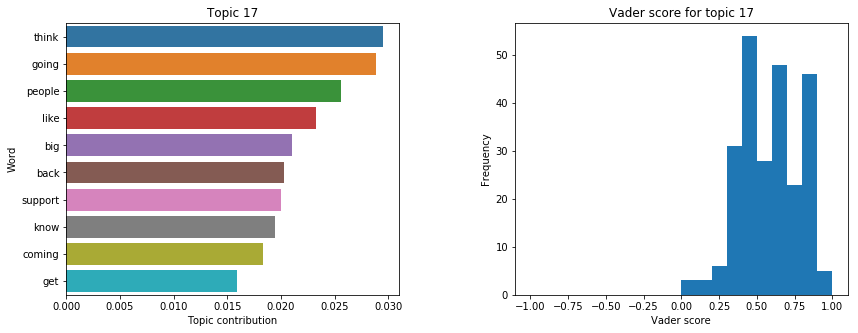

In [9]:
process(pre,"positive")

# Obama

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5841


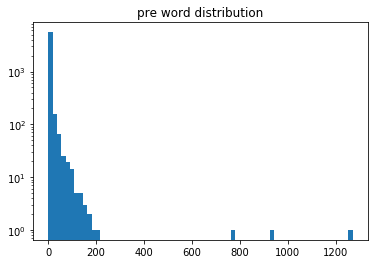

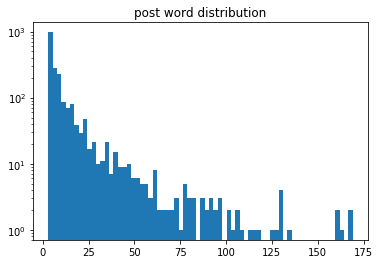

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


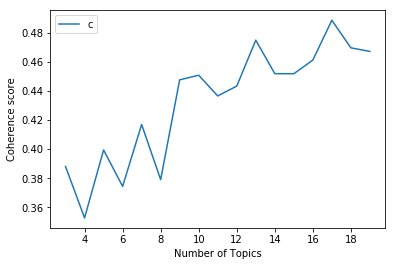

17
3095 3095


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
NUMBER OF ELEMENTS FOR THIS TOPIC 1656
Corpus length in words: 13724


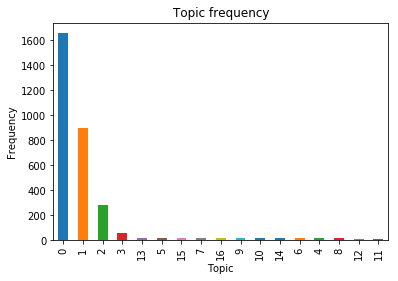

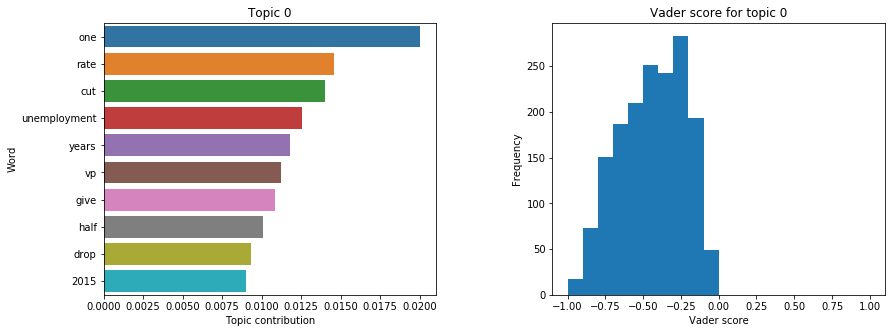

1
NUMBER OF ELEMENTS FOR THIS TOPIC 894
Corpus length in words: 7539


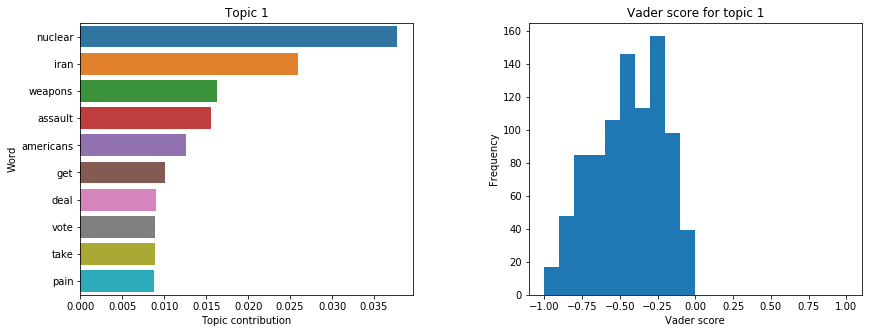

2
NUMBER OF ELEMENTS FOR THIS TOPIC 284
Corpus length in words: 2451


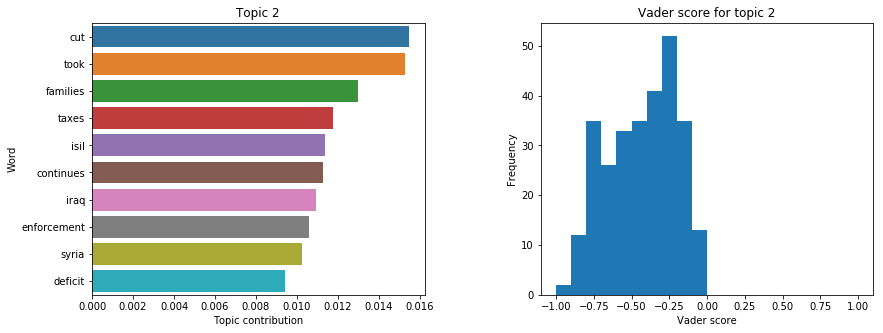

3
NUMBER OF ELEMENTS FOR THIS TOPIC 57
Corpus length in words: 465


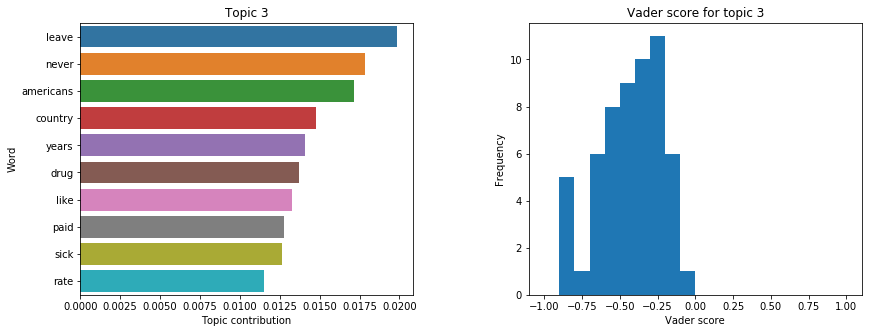

4
NUMBER OF ELEMENTS FOR THIS TOPIC 15
Corpus length in words: 97


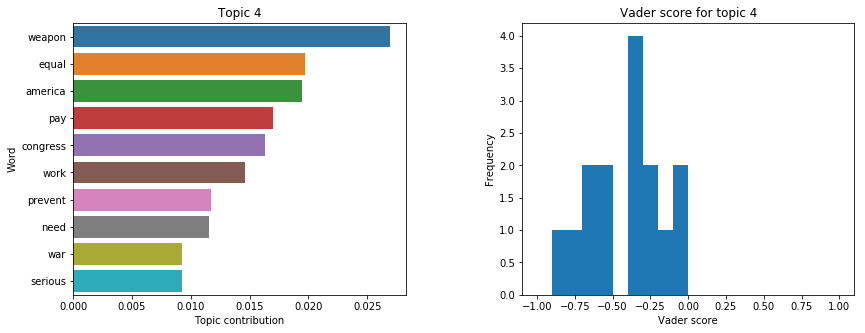

5
NUMBER OF ELEMENTS FOR THIS TOPIC 20
Corpus length in words: 73


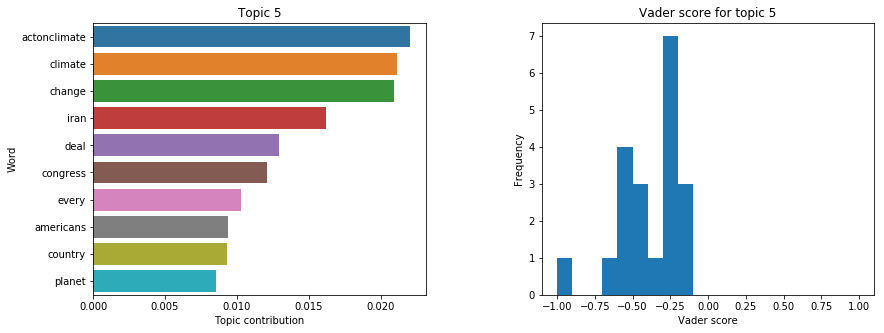

6
NUMBER OF ELEMENTS FOR THIS TOPIC 15
Corpus length in words: 64


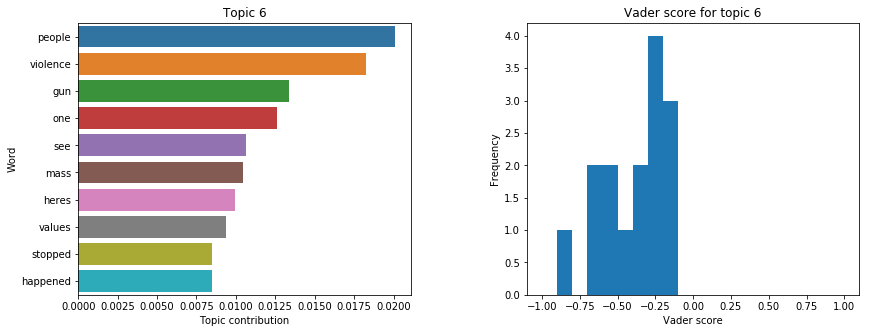

7
NUMBER OF ELEMENTS FOR THIS TOPIC 18
Corpus length in words: 83


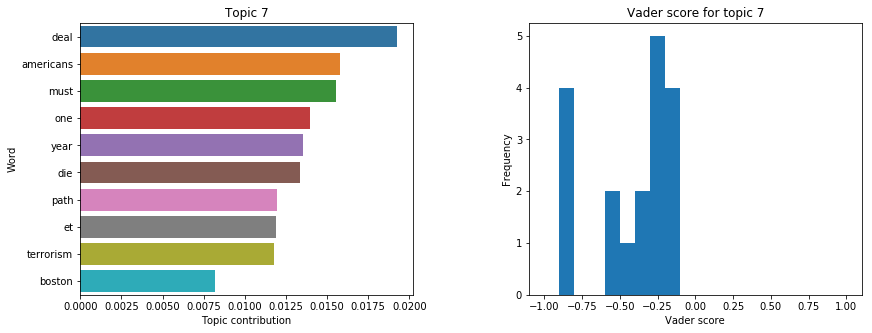

8
NUMBER OF ELEMENTS FOR THIS TOPIC 14
Corpus length in words: 62


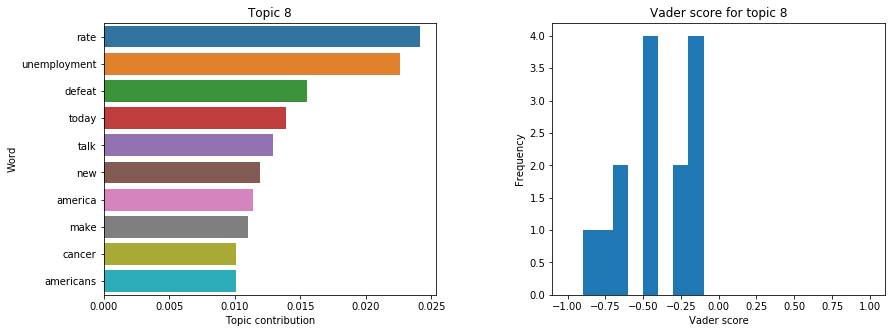

9
NUMBER OF ELEMENTS FOR THIS TOPIC 16
Corpus length in words: 57


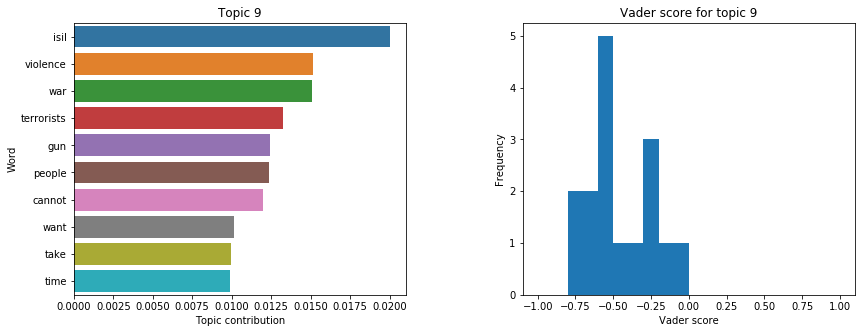

10
NUMBER OF ELEMENTS FOR THIS TOPIC 16
Corpus length in words: 69


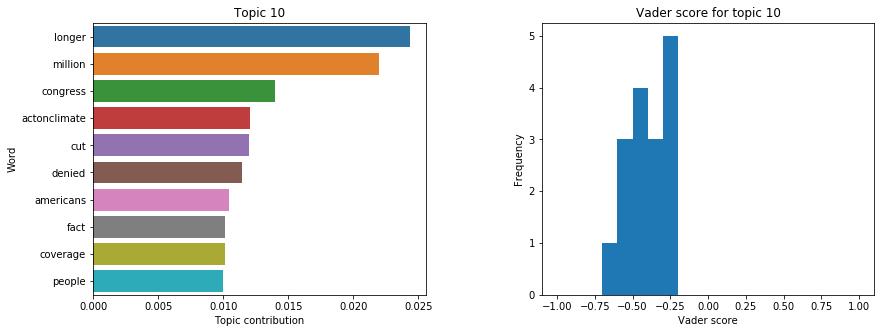

11
NUMBER OF ELEMENTS FOR THIS TOPIC 8
Corpus length in words: 29


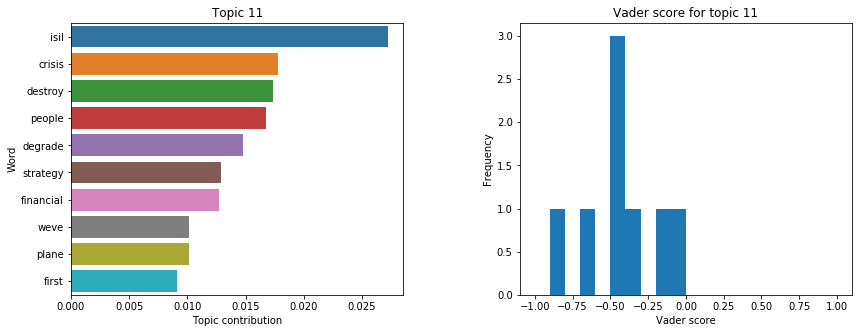

12
NUMBER OF ELEMENTS FOR THIS TOPIC 11
Corpus length in words: 37


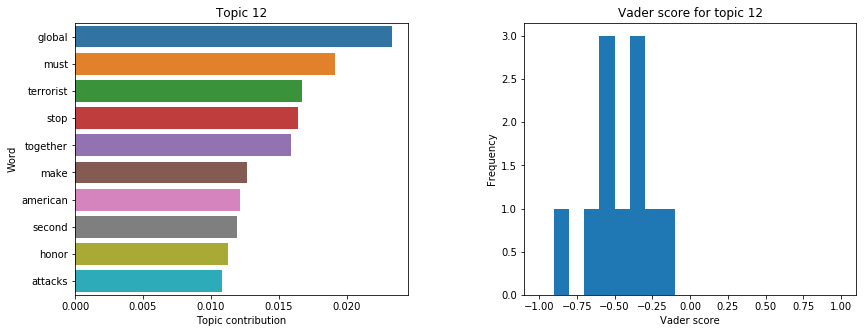

13
NUMBER OF ELEMENTS FOR THIS TOPIC 20
Corpus length in words: 88


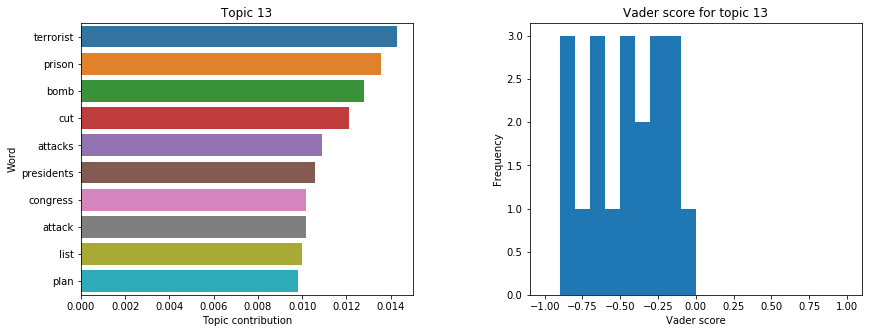

14
NUMBER OF ELEMENTS FOR THIS TOPIC 15
Corpus length in words: 62


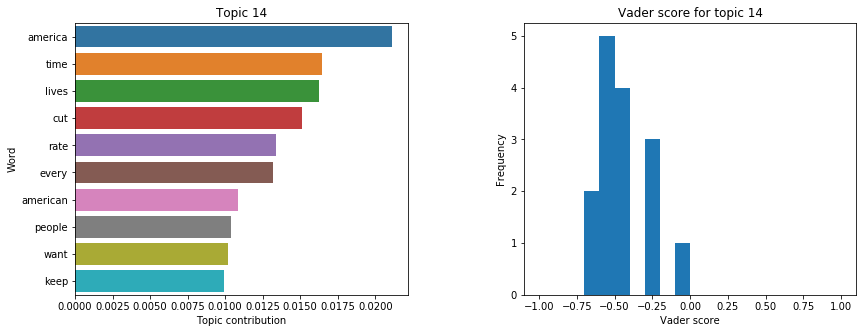

15
NUMBER OF ELEMENTS FOR THIS TOPIC 19
Corpus length in words: 78


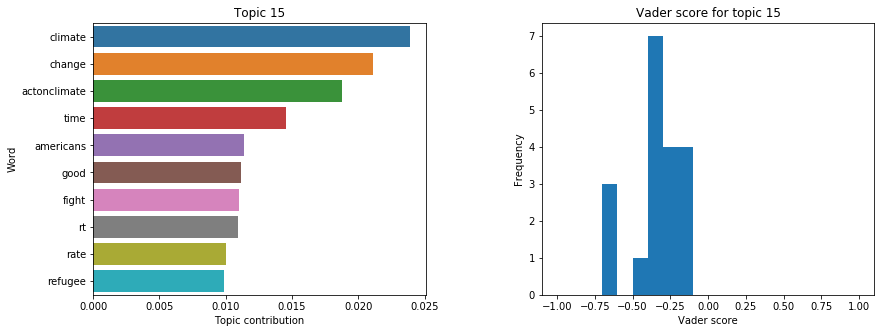

16
NUMBER OF ELEMENTS FOR THIS TOPIC 17
Corpus length in words: 72


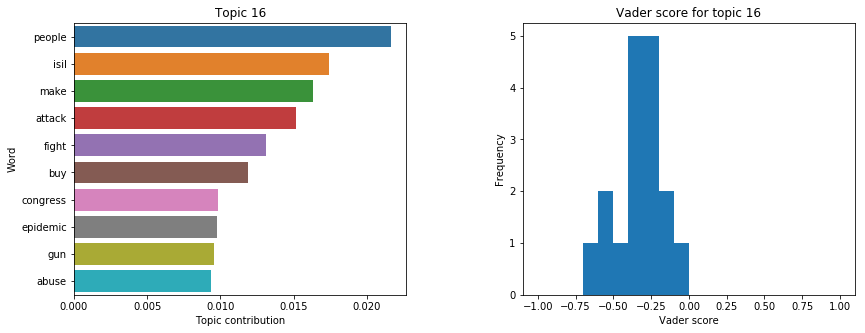

In [18]:
obama = pd.read_csv("obamaprocessed.csv")
process1(obama,"negative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


8205


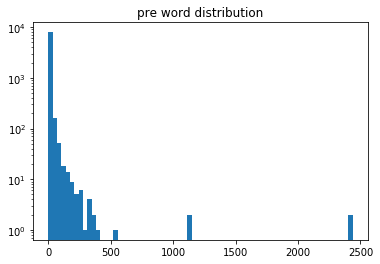

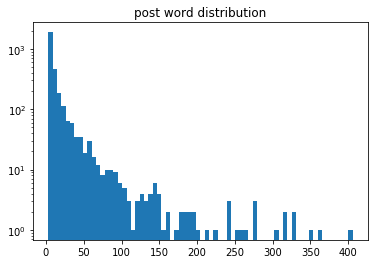

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


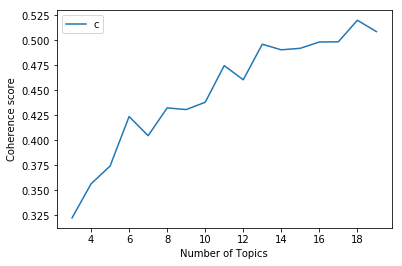

18
6319 6319
0
NUMBER OF ELEMENTS FOR THIS TOPIC 2026
Corpus length in words: 16430


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


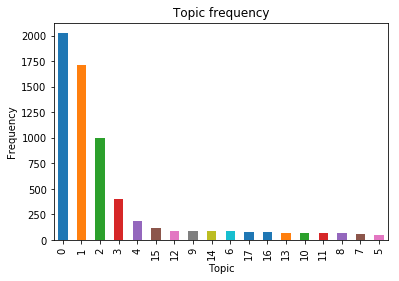

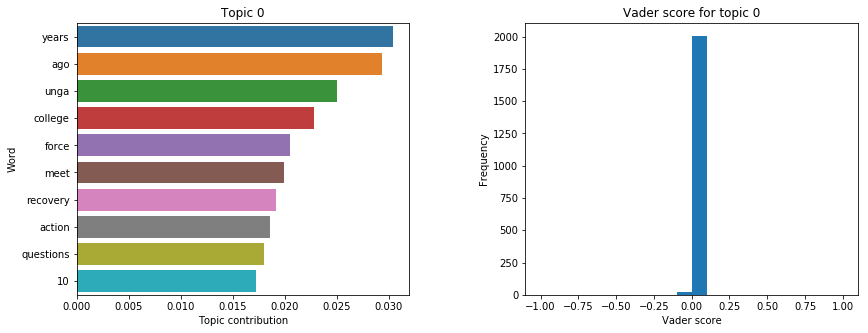

1
NUMBER OF ELEMENTS FOR THIS TOPIC 1709
Corpus length in words: 13595


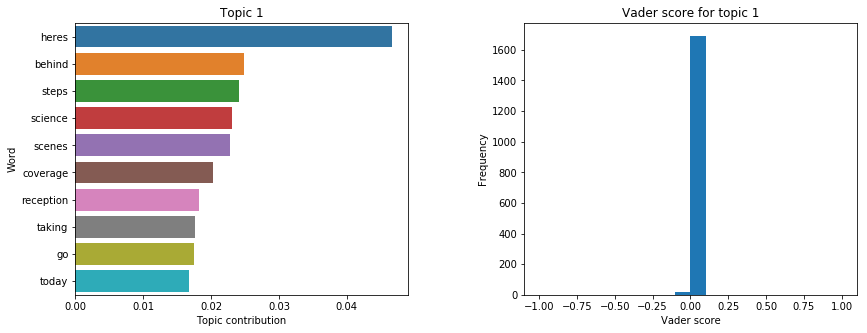

2
NUMBER OF ELEMENTS FOR THIS TOPIC 1003
Corpus length in words: 8002


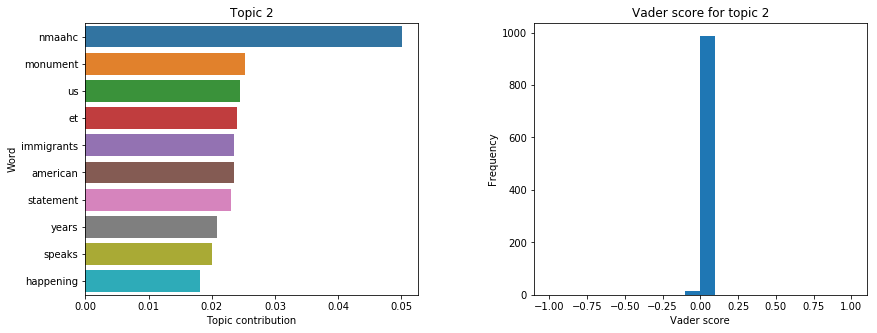

3
NUMBER OF ELEMENTS FOR THIS TOPIC 398
Corpus length in words: 3321


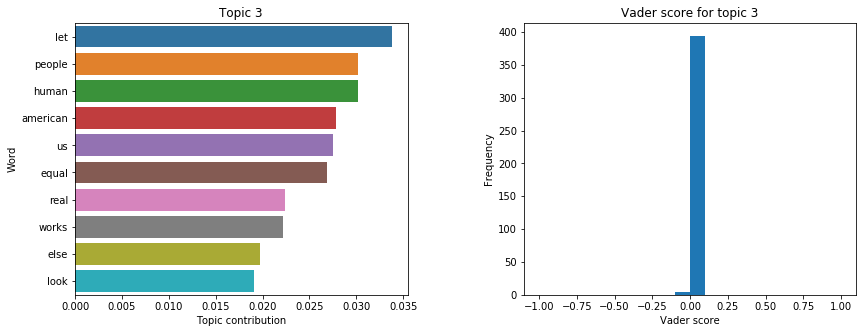

4
NUMBER OF ELEMENTS FOR THIS TOPIC 186
Corpus length in words: 1268


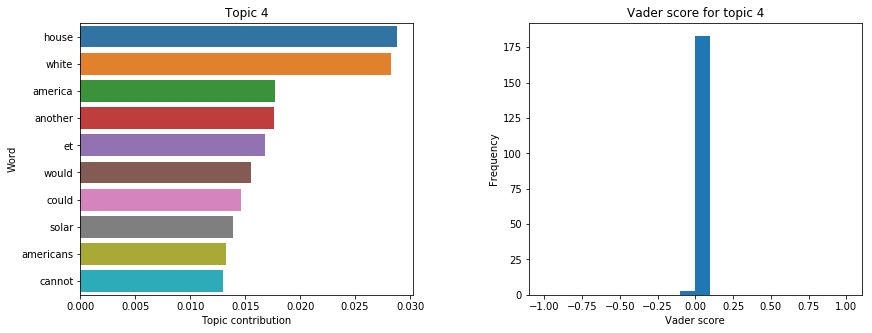

5
NUMBER OF ELEMENTS FOR THIS TOPIC 52
Corpus length in words: 291


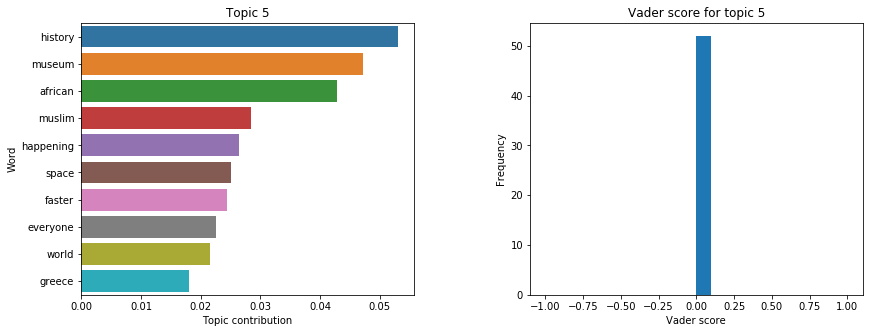

6
NUMBER OF ELEMENTS FOR THIS TOPIC 85
Corpus length in words: 371


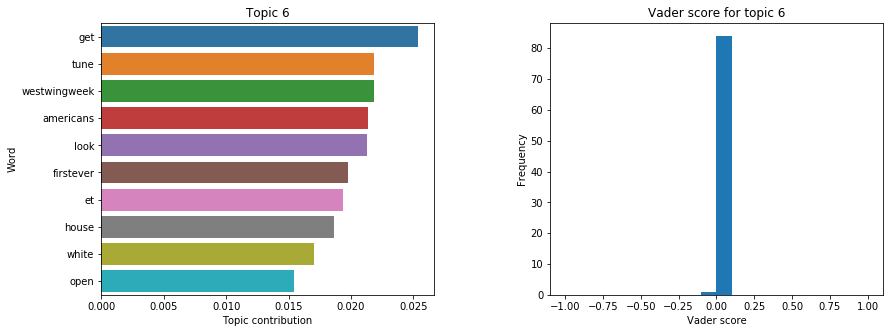

7
NUMBER OF ELEMENTS FOR THIS TOPIC 61
Corpus length in words: 247


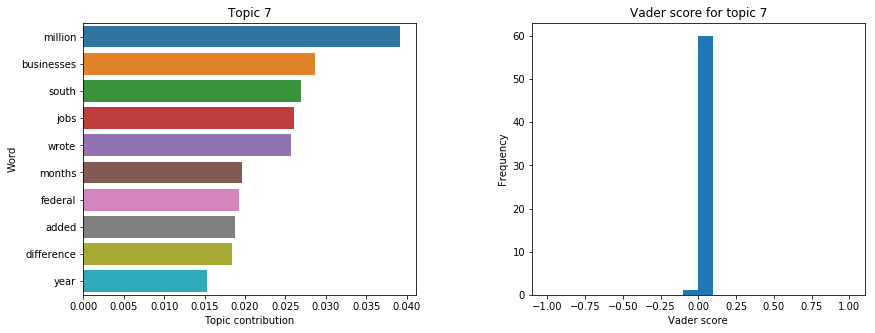

8
NUMBER OF ELEMENTS FOR THIS TOPIC 65
Corpus length in words: 318


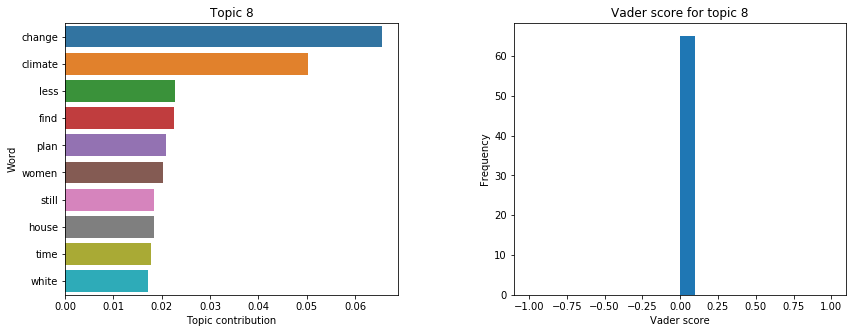

9
NUMBER OF ELEMENTS FOR THIS TOPIC 86
Corpus length in words: 383


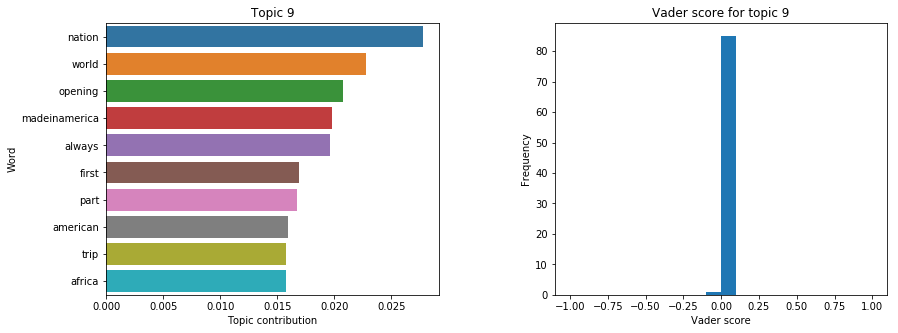

10
NUMBER OF ELEMENTS FOR THIS TOPIC 69
Corpus length in words: 298


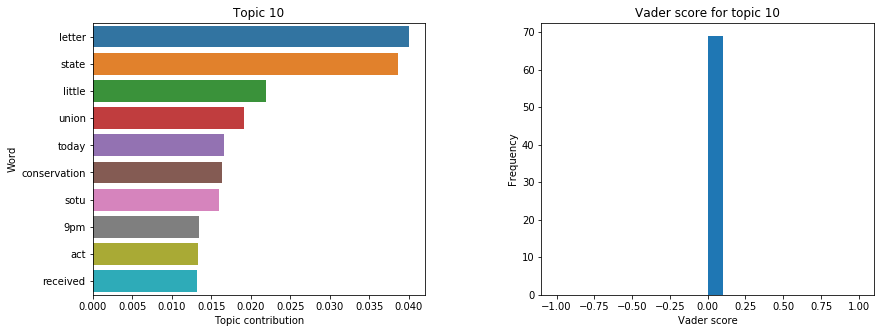

11
NUMBER OF ELEMENTS FOR THIS TOPIC 65
Corpus length in words: 258


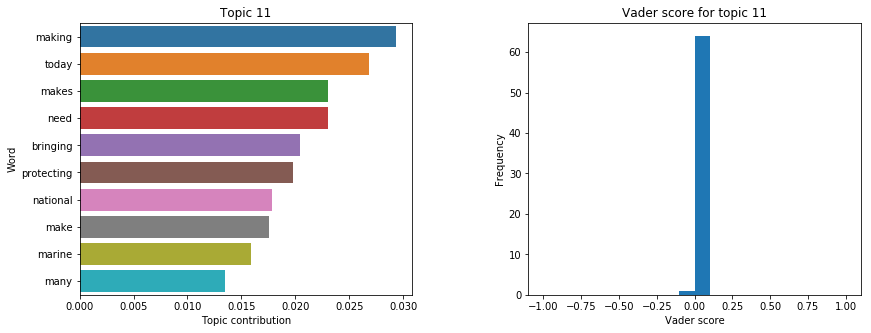

12
NUMBER OF ELEMENTS FOR THIS TOPIC 90
Corpus length in words: 391


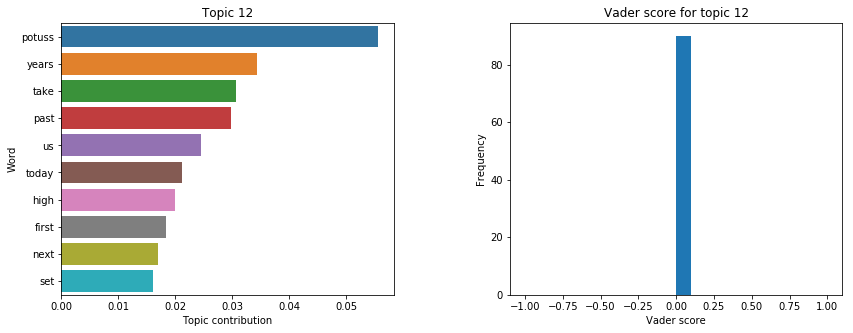

13
NUMBER OF ELEMENTS FOR THIS TOPIC 71
Corpus length in words: 304


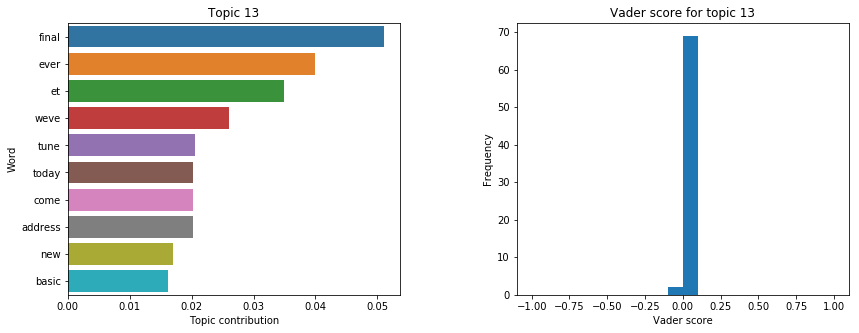

14
NUMBER OF ELEMENTS FOR THIS TOPIC 86
Corpus length in words: 413


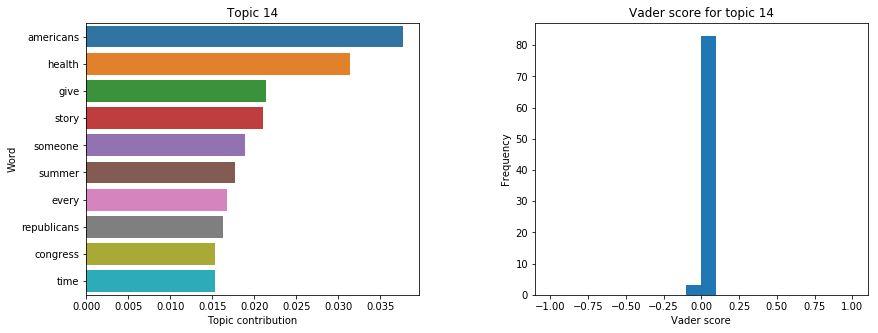

15
NUMBER OF ELEMENTS FOR THIS TOPIC 113
Corpus length in words: 460


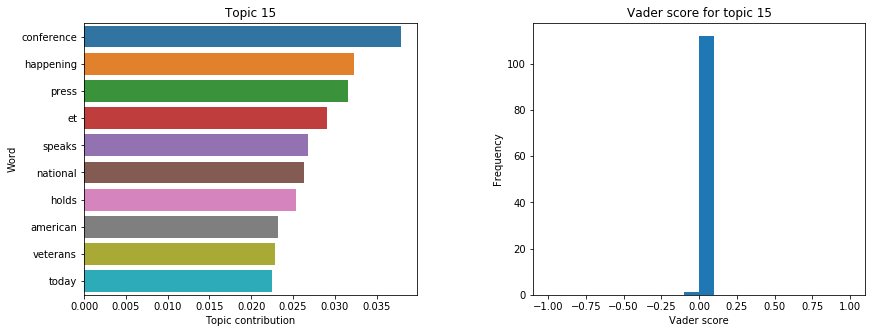

16
NUMBER OF ELEMENTS FOR THIS TOPIC 77
Corpus length in words: 342


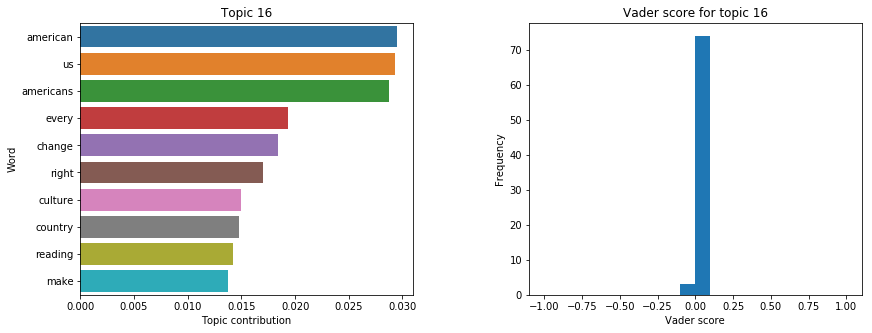

17
NUMBER OF ELEMENTS FOR THIS TOPIC 77
Corpus length in words: 303


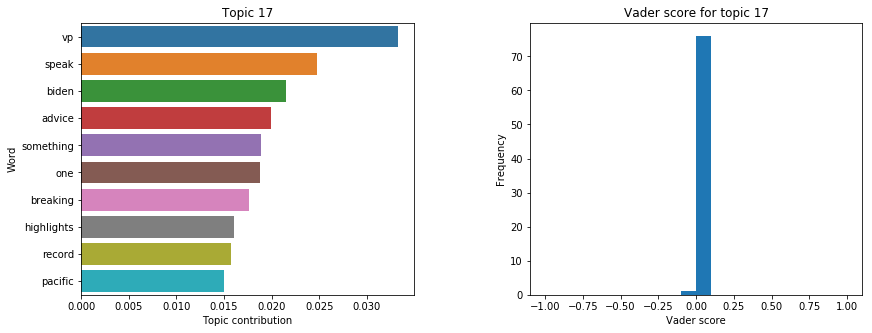

In [20]:
obama = pd.read_csv("obamaprocessed.csv")
process1(obama,"neutral")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


10064


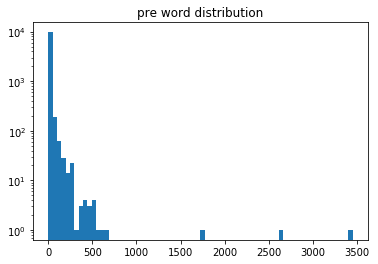

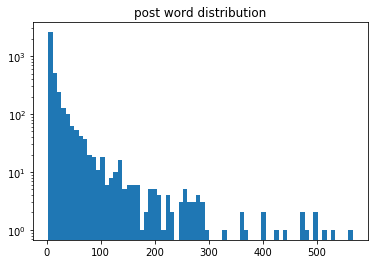

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


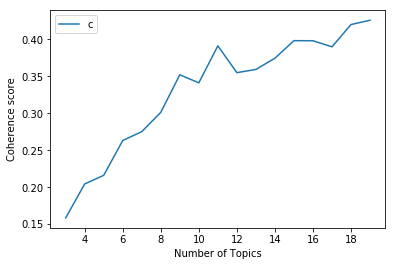

19
9055 9055
0
NUMBER OF ELEMENTS FOR THIS TOPIC 2833
Corpus length in words: 25149


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


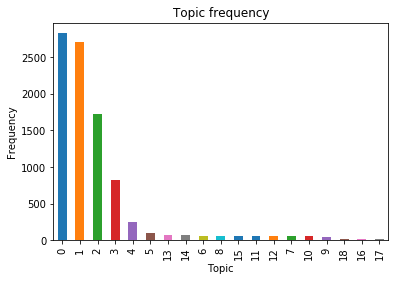

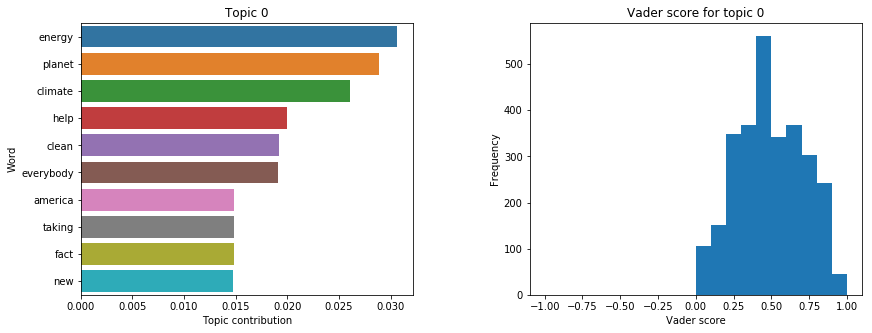

1
NUMBER OF ELEMENTS FOR THIS TOPIC 2709
Corpus length in words: 24267


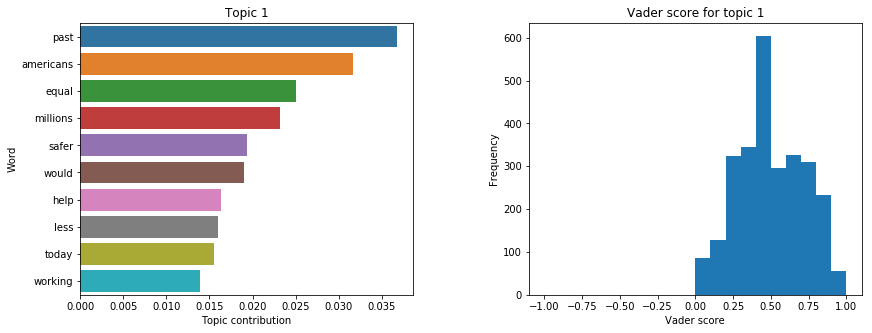

2
NUMBER OF ELEMENTS FOR THIS TOPIC 1727
Corpus length in words: 15847


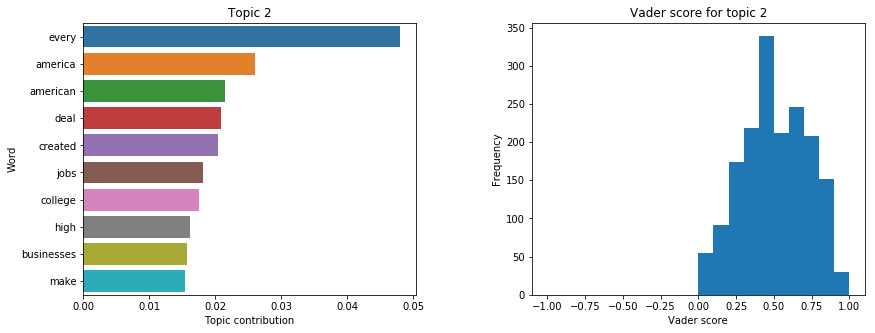

3
NUMBER OF ELEMENTS FOR THIS TOPIC 816
Corpus length in words: 7725


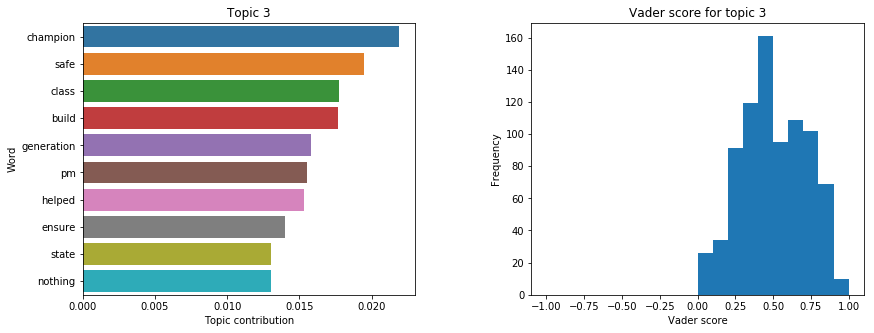

4
NUMBER OF ELEMENTS FOR THIS TOPIC 248
Corpus length in words: 2315


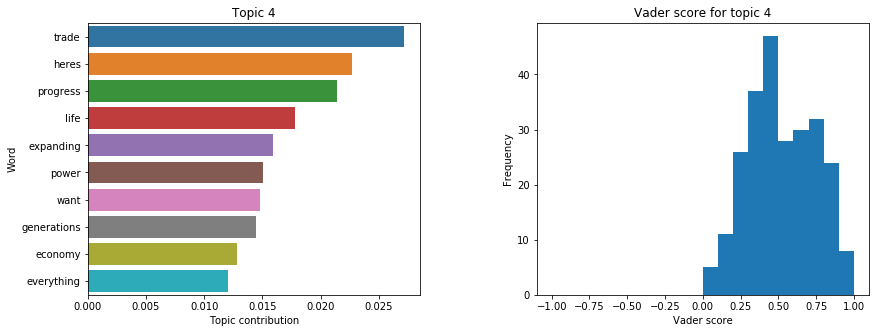

5
NUMBER OF ELEMENTS FOR THIS TOPIC 92
Corpus length in words: 672


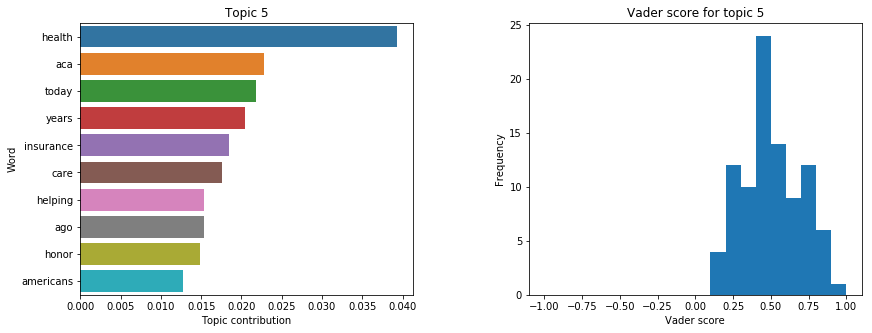

6
NUMBER OF ELEMENTS FOR THIS TOPIC 62
Corpus length in words: 366


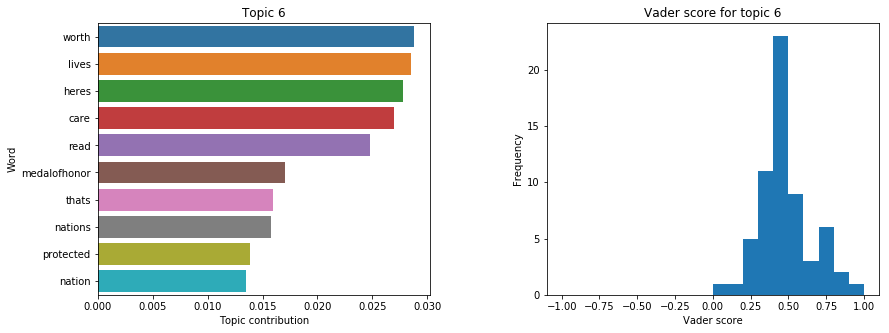

7
NUMBER OF ELEMENTS FOR THIS TOPIC 55
Corpus length in words: 273


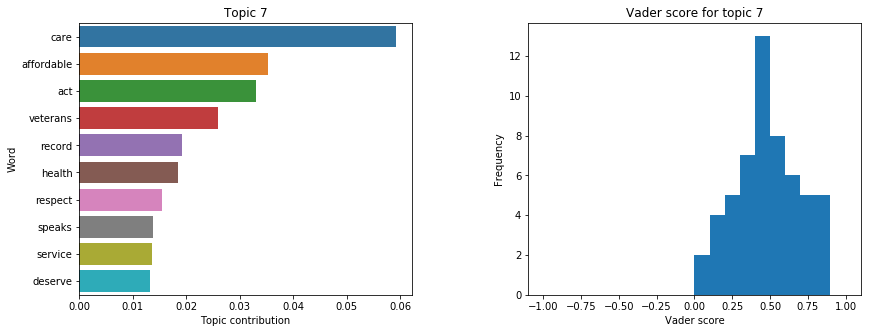

8
NUMBER OF ELEMENTS FOR THIS TOPIC 60
Corpus length in words: 301


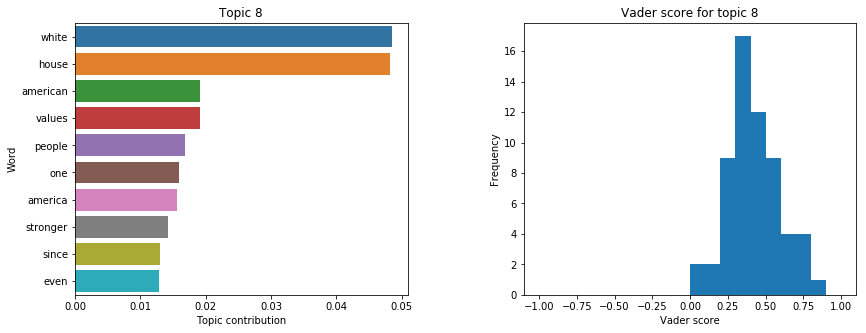

9
NUMBER OF ELEMENTS FOR THIS TOPIC 44
Corpus length in words: 223


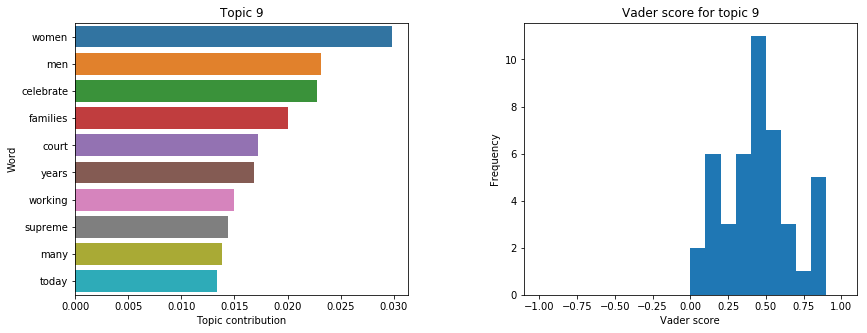

10
NUMBER OF ELEMENTS FOR THIS TOPIC 52
Corpus length in words: 252


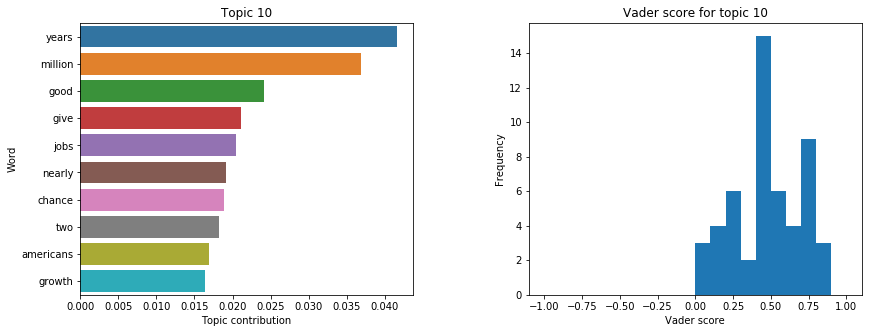

11
NUMBER OF ELEMENTS FOR THIS TOPIC 57
Corpus length in words: 247


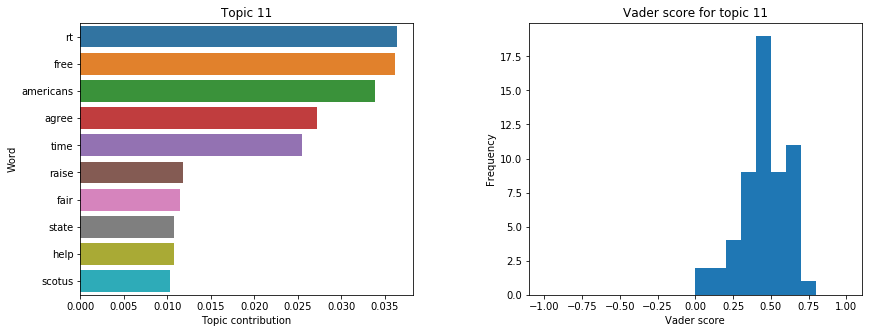

12
NUMBER OF ELEMENTS FOR THIS TOPIC 56
Corpus length in words: 253


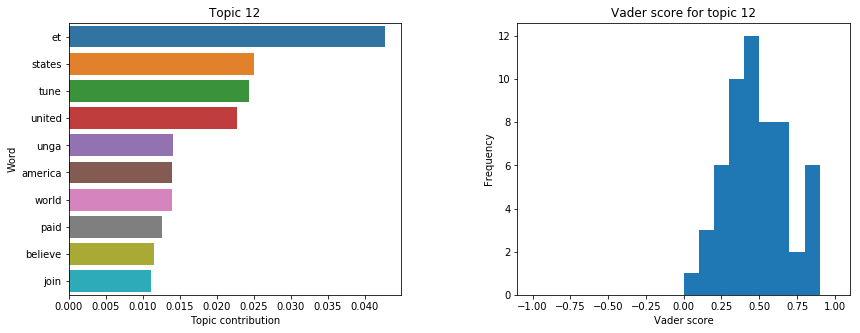

13
NUMBER OF ELEMENTS FOR THIS TOPIC 67
Corpus length in words: 297


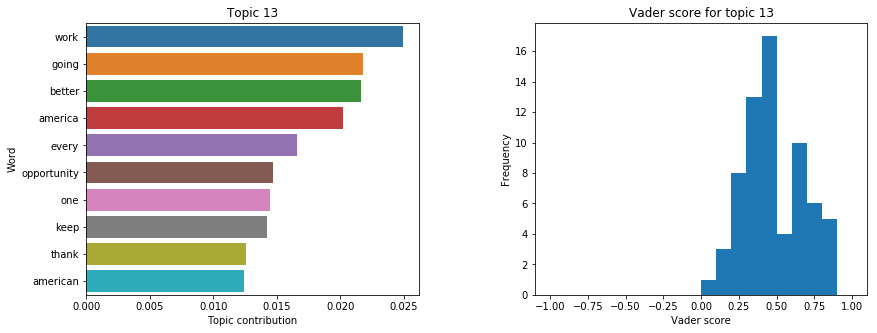

14
NUMBER OF ELEMENTS FOR THIS TOPIC 65
Corpus length in words: 325


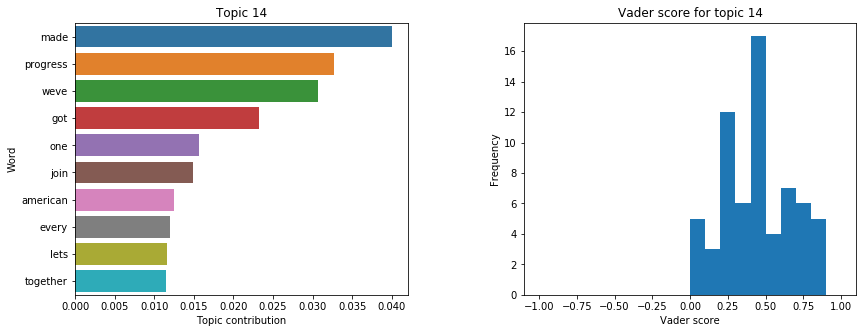

15
NUMBER OF ELEMENTS FOR THIS TOPIC 58
Corpus length in words: 170


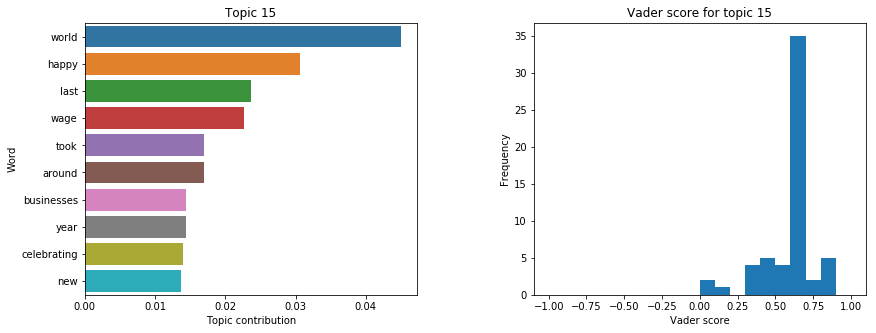

16
NUMBER OF ELEMENTS FOR THIS TOPIC 18
Corpus length in words: 69


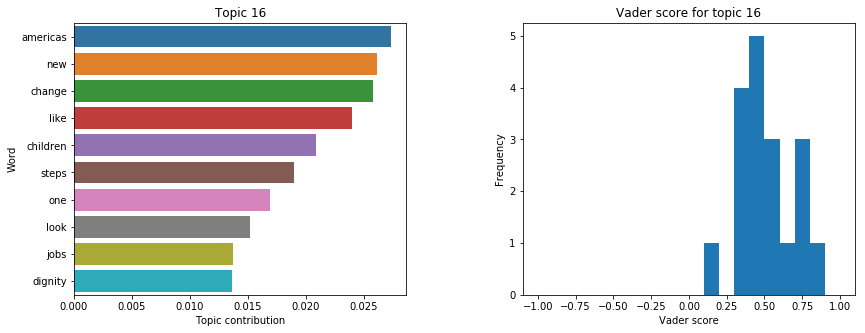

17
NUMBER OF ELEMENTS FOR THIS TOPIC 17
Corpus length in words: 66


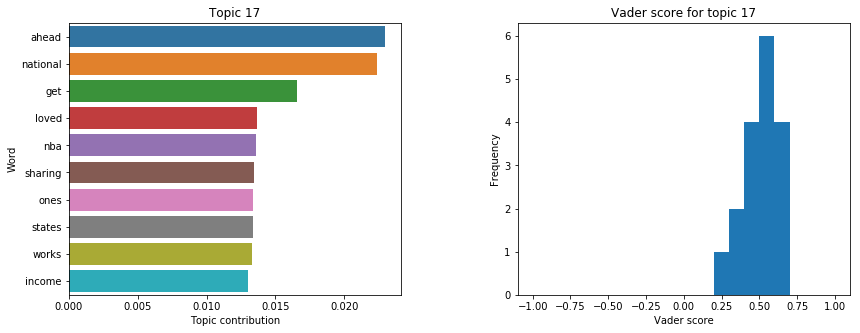

18
NUMBER OF ELEMENTS FOR THIS TOPIC 19
Corpus length in words: 85


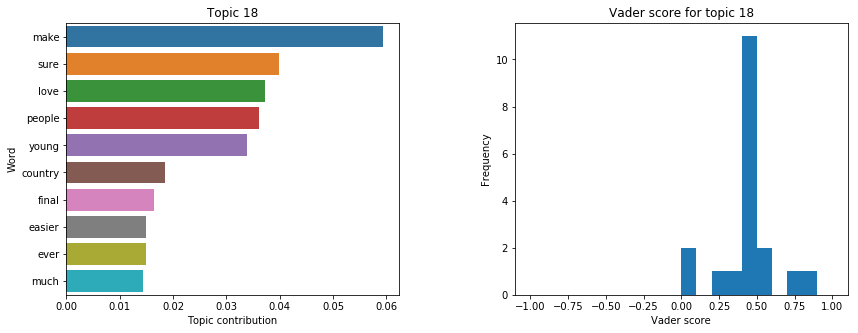

In [21]:
obama = pd.read_csv("obamaprocessed.csv")
process1(obama,"positive")

# POST

In [22]:
post = data[data["year"] >= 2016]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


7519


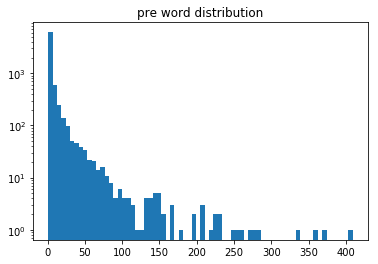

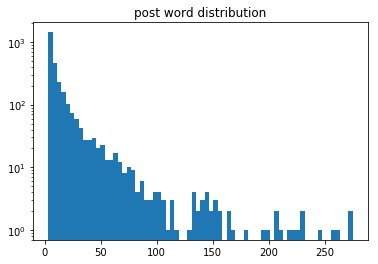

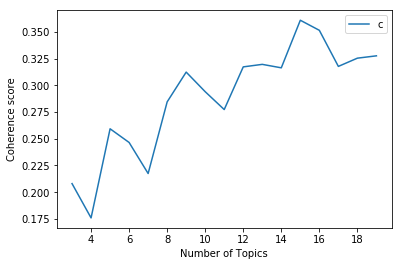

15
3142 3142
0
NUMBER OF ELEMENTS FOR THIS TOPIC 1675
Corpus length in words: 21443


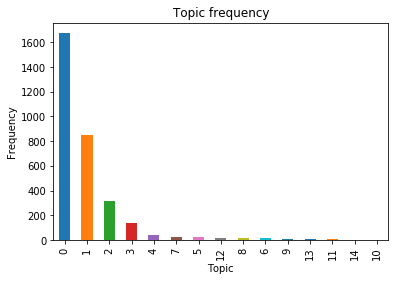

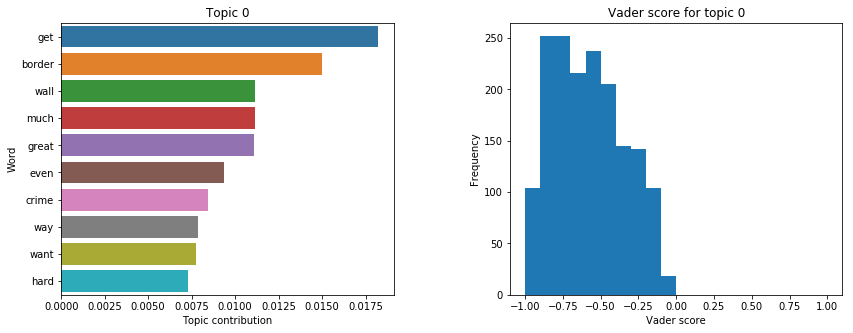

1
NUMBER OF ELEMENTS FOR THIS TOPIC 846
Corpus length in words: 12160


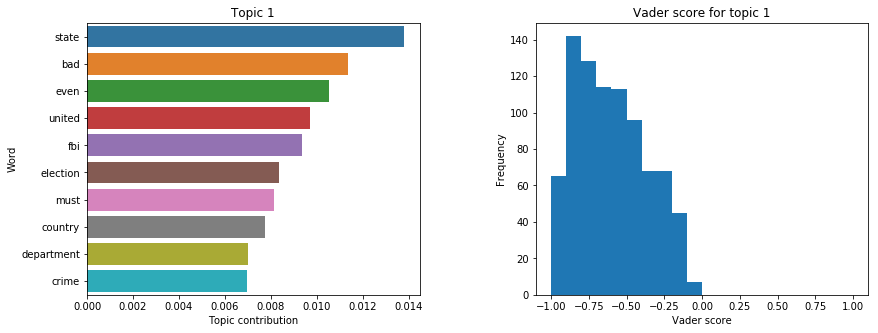

2
NUMBER OF ELEMENTS FOR THIS TOPIC 315
Corpus length in words: 5519


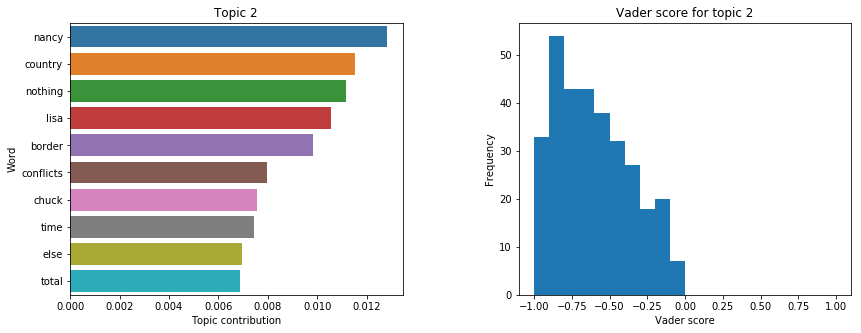

3
NUMBER OF ELEMENTS FOR THIS TOPIC 137
Corpus length in words: 2585


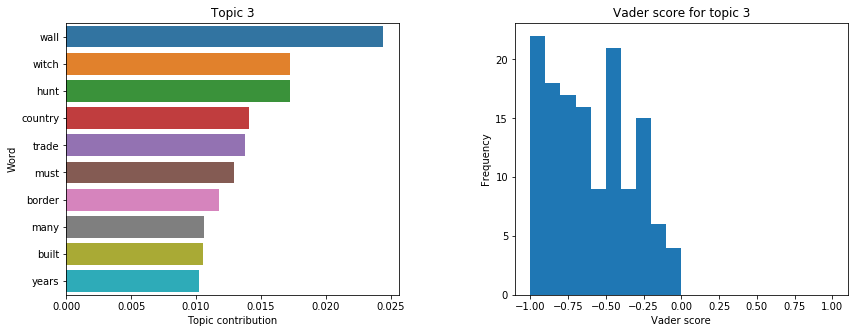

4
NUMBER OF ELEMENTS FOR THIS TOPIC 40
Corpus length in words: 799


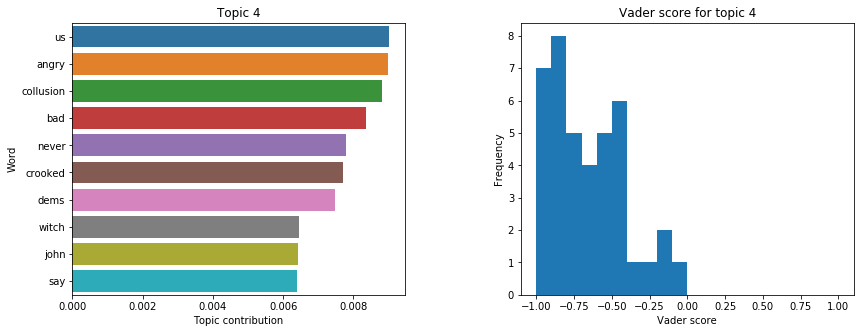

5
NUMBER OF ELEMENTS FOR THIS TOPIC 21
Corpus length in words: 191


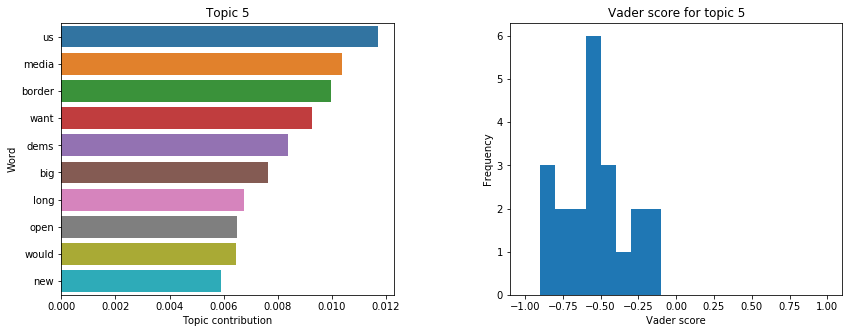

6
NUMBER OF ELEMENTS FOR THIS TOPIC 15
Corpus length in words: 93


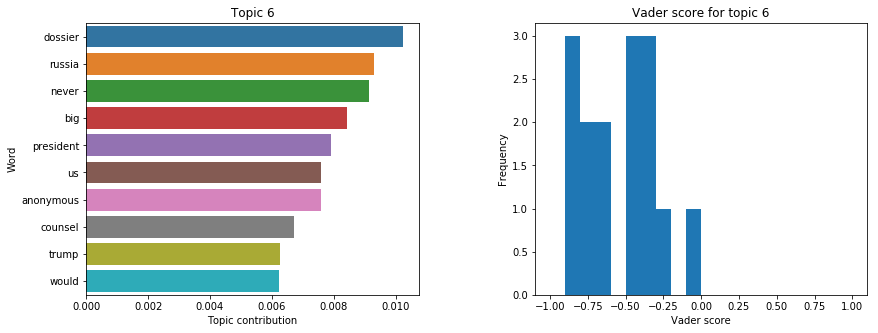

7
NUMBER OF ELEMENTS FOR THIS TOPIC 23
Corpus length in words: 110


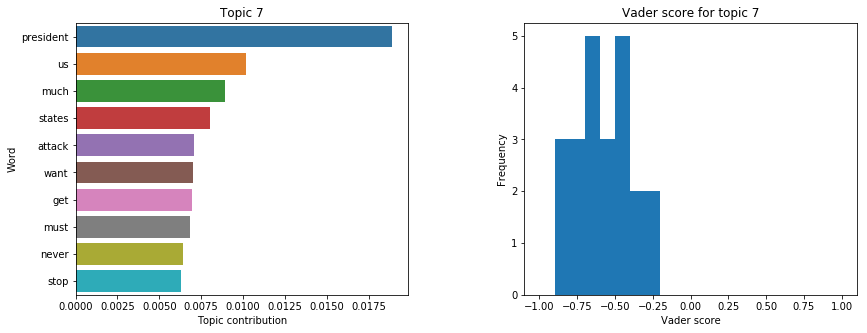

8
NUMBER OF ELEMENTS FOR THIS TOPIC 17
Corpus length in words: 71


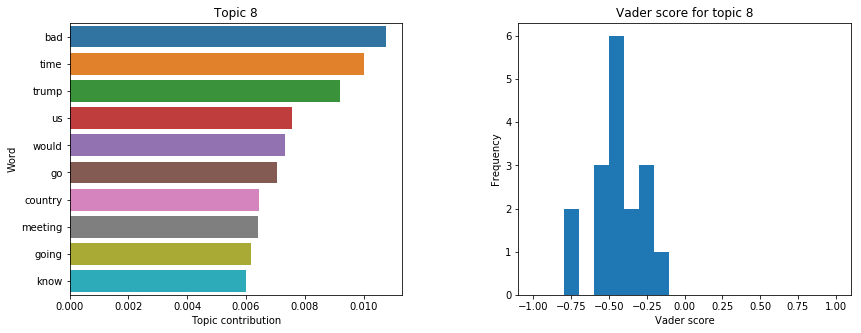

9
NUMBER OF ELEMENTS FOR THIS TOPIC 10
Corpus length in words: 26


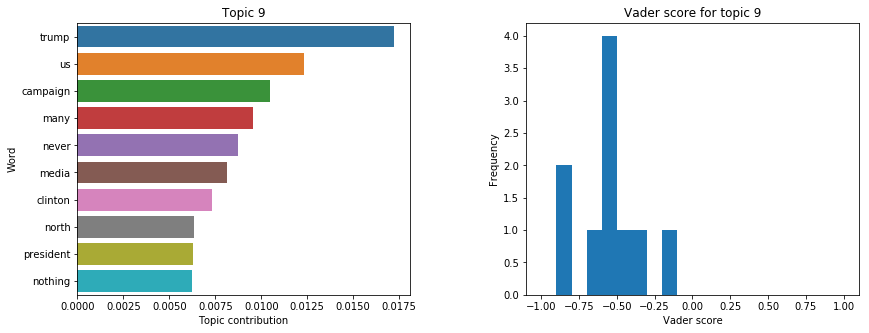

10
NUMBER OF ELEMENTS FOR THIS TOPIC 3
Corpus length in words: 8


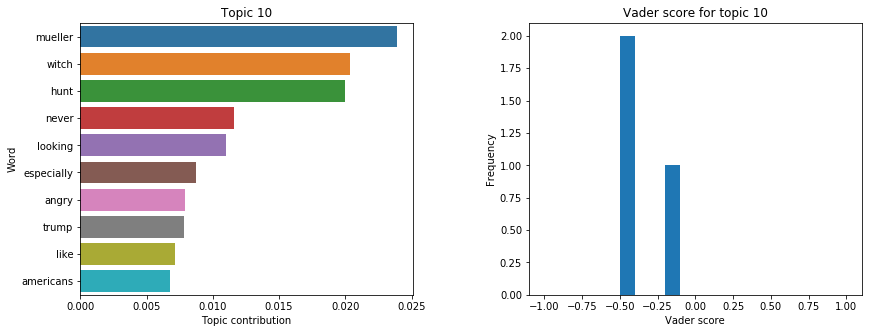

11
NUMBER OF ELEMENTS FOR THIS TOPIC 8
Corpus length in words: 27


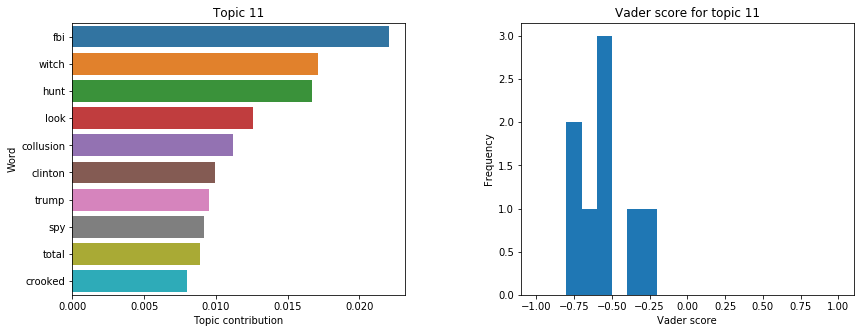

12
NUMBER OF ELEMENTS FOR THIS TOPIC 19
Corpus length in words: 47


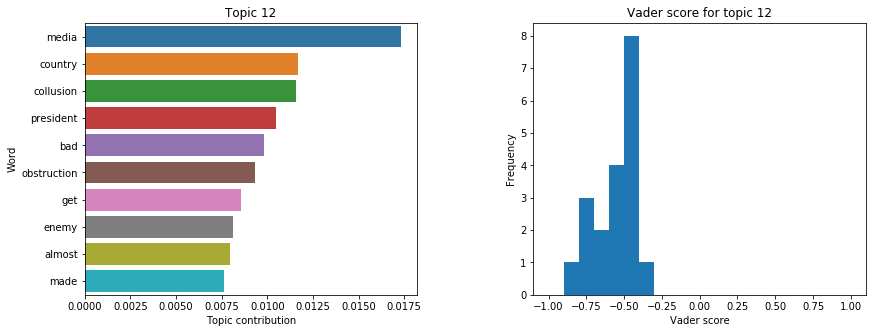

13
NUMBER OF ELEMENTS FOR THIS TOPIC 9
Corpus length in words: 31


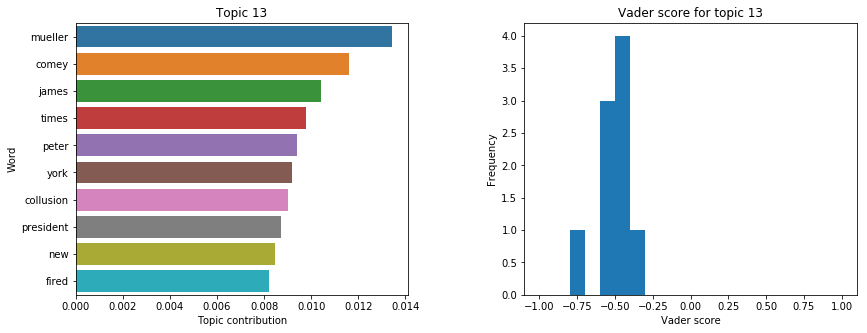

14
NUMBER OF ELEMENTS FOR THIS TOPIC 4
Corpus length in words: 15


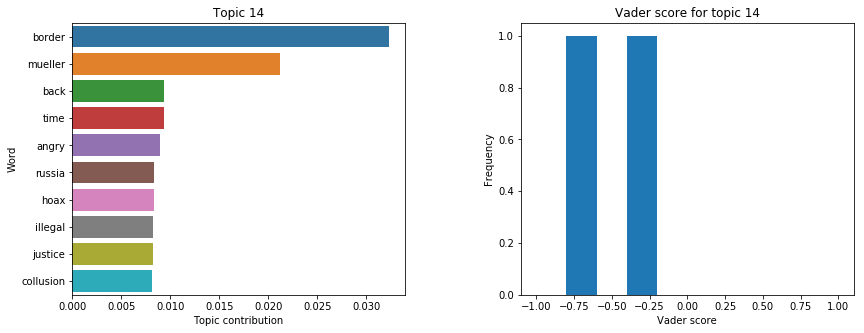

In [23]:
process(post,"negative")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


3380


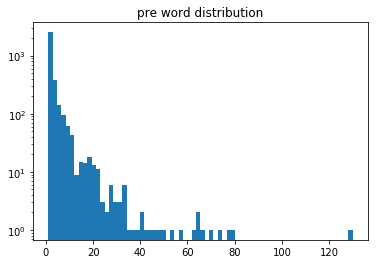

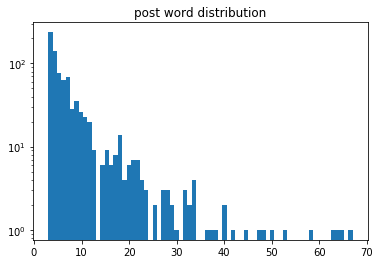

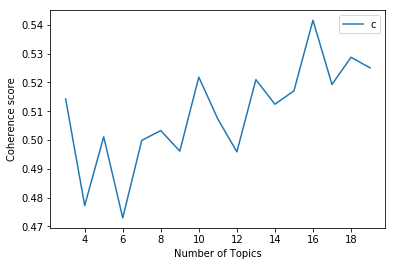

16
1210 1210
0
NUMBER OF ELEMENTS FOR THIS TOPIC 658
Corpus length in words: 5071


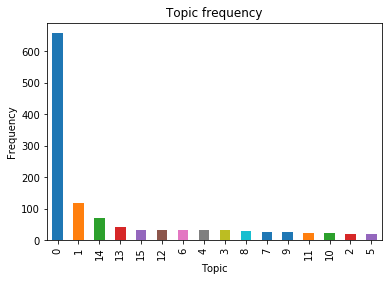

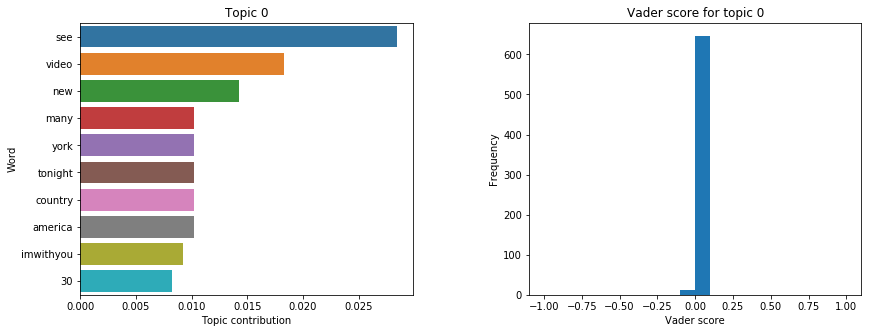

1
NUMBER OF ELEMENTS FOR THIS TOPIC 119
Corpus length in words: 520


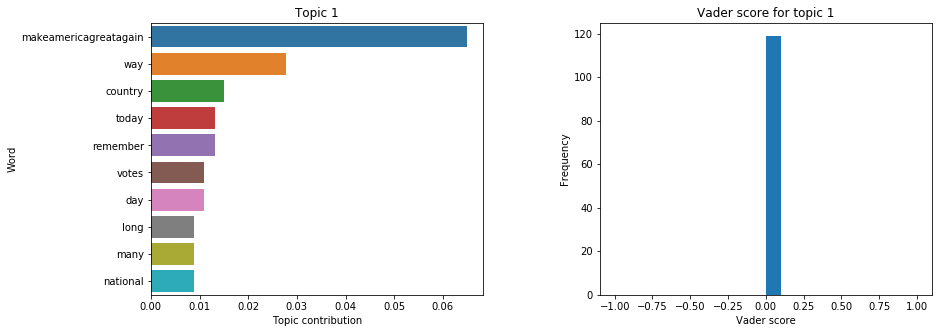

2
NUMBER OF ELEMENTS FOR THIS TOPIC 20
Corpus length in words: 64


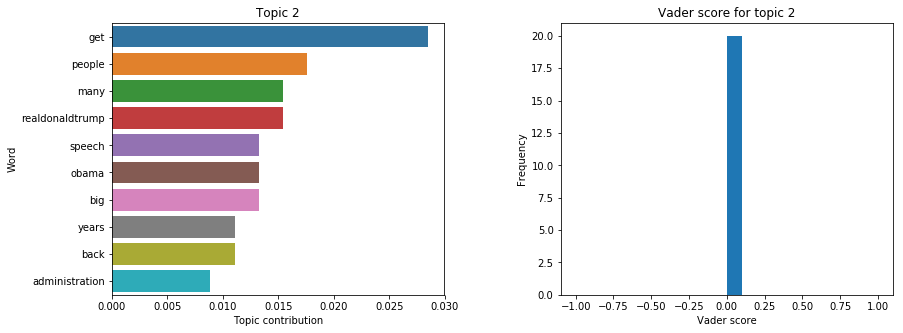

3
NUMBER OF ELEMENTS FOR THIS TOPIC 32
Corpus length in words: 93


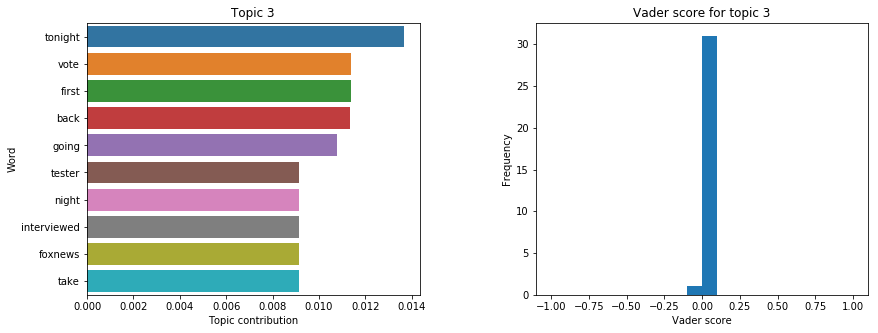

4
NUMBER OF ELEMENTS FOR THIS TOPIC 32
Corpus length in words: 94


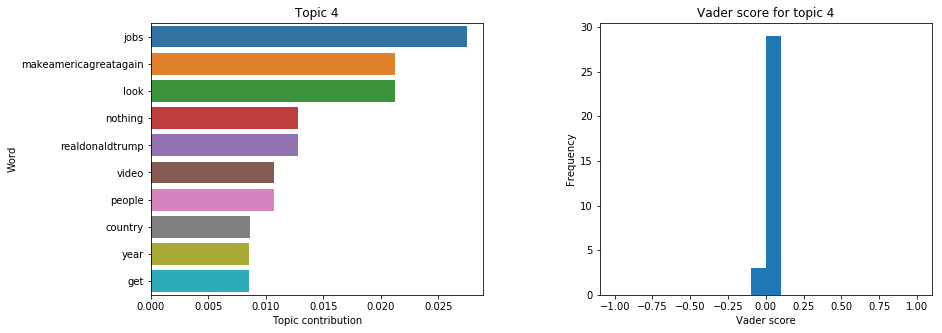

5
NUMBER OF ELEMENTS FOR THIS TOPIC 19
Corpus length in words: 49


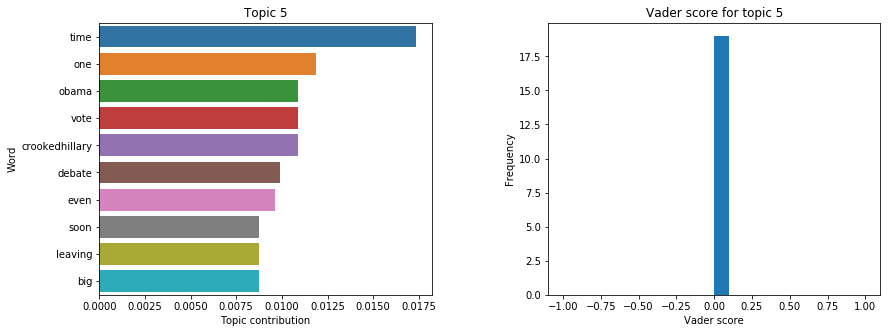

6
NUMBER OF ELEMENTS FOR THIS TOPIC 32
Corpus length in words: 83


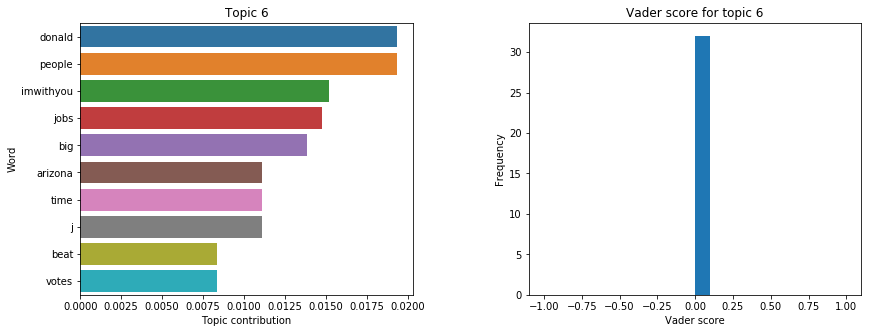

7
NUMBER OF ELEMENTS FOR THIS TOPIC 26
Corpus length in words: 66


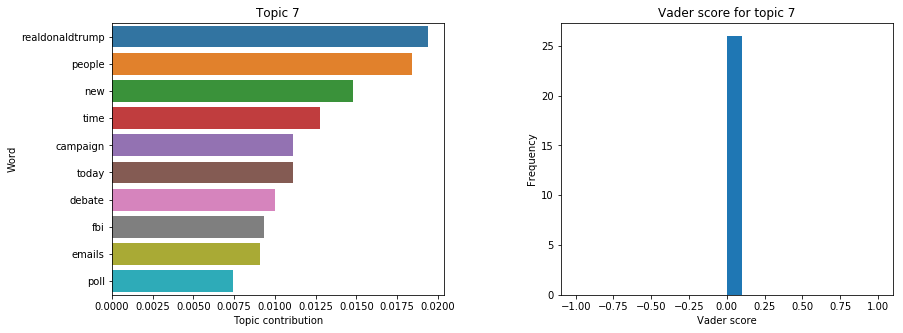

8
NUMBER OF ELEMENTS FOR THIS TOPIC 30
Corpus length in words: 79


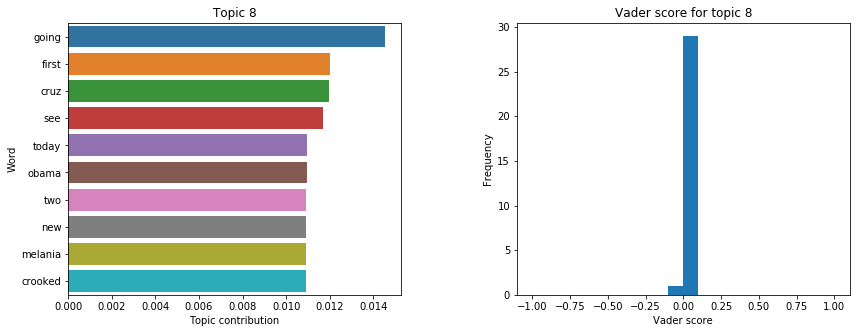

9
NUMBER OF ELEMENTS FOR THIS TOPIC 25
Corpus length in words: 56


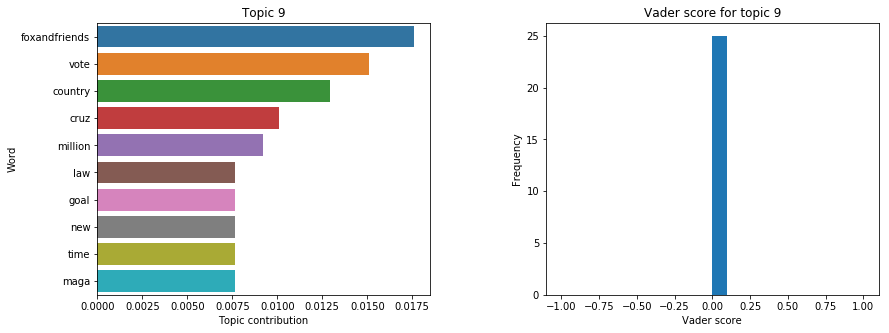

10
NUMBER OF ELEMENTS FOR THIS TOPIC 21
Corpus length in words: 66


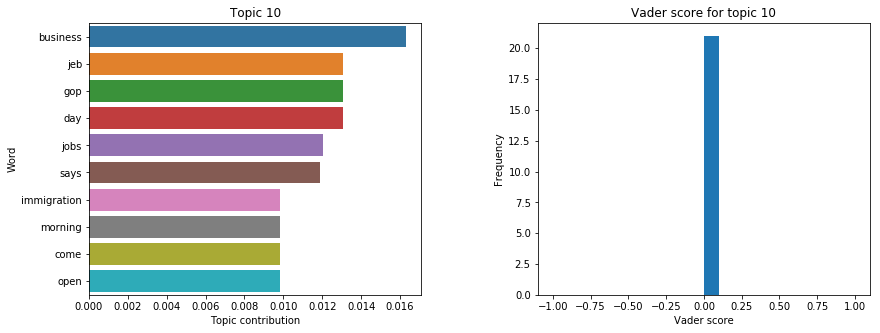

11
NUMBER OF ELEMENTS FOR THIS TOPIC 21
Corpus length in words: 55


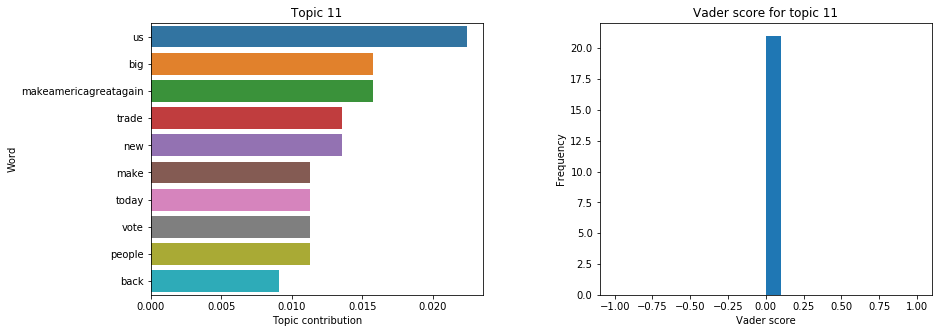

12
NUMBER OF ELEMENTS FOR THIS TOPIC 33
Corpus length in words: 90


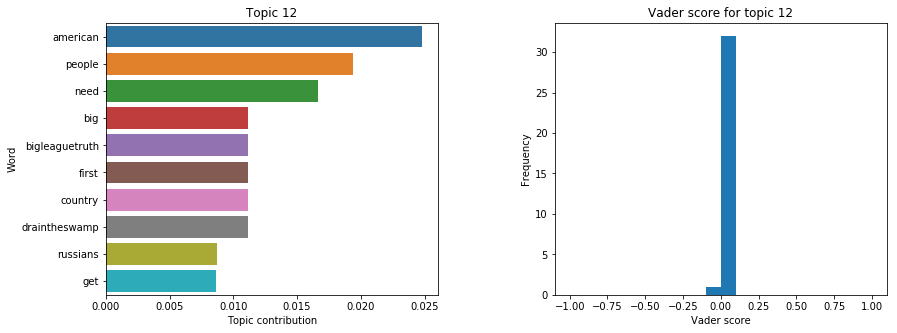

13
NUMBER OF ELEMENTS FOR THIS TOPIC 40
Corpus length in words: 89


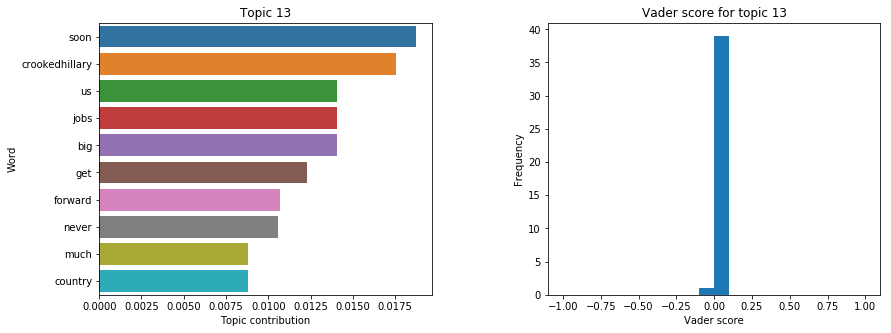

14
NUMBER OF ELEMENTS FOR THIS TOPIC 69
Corpus length in words: 126


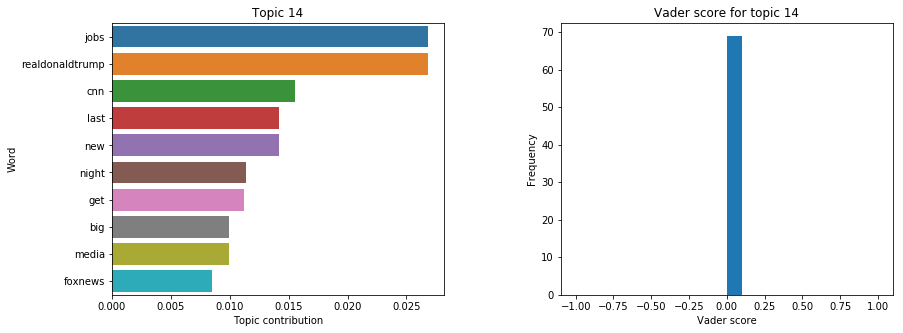

15
NUMBER OF ELEMENTS FOR THIS TOPIC 33
Corpus length in words: 80


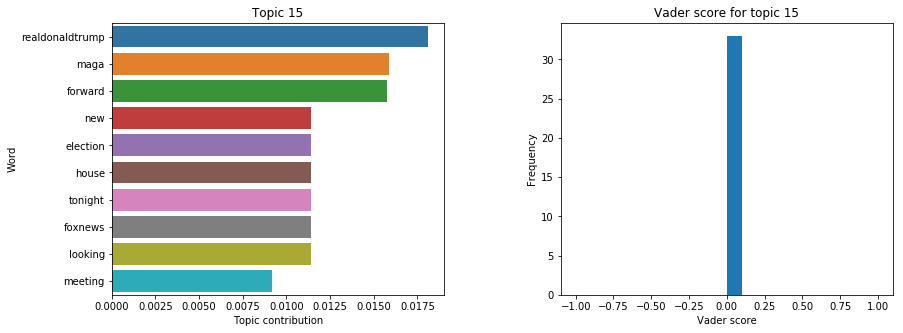

In [24]:
process(post,"neutral")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


9553


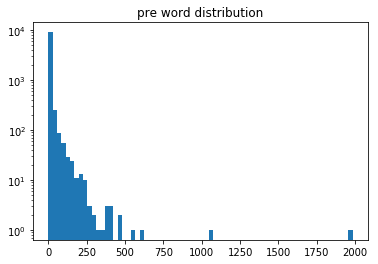

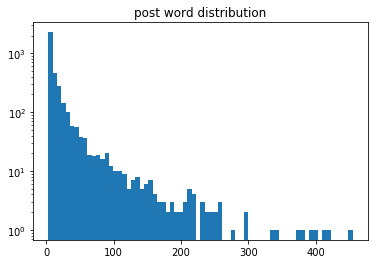

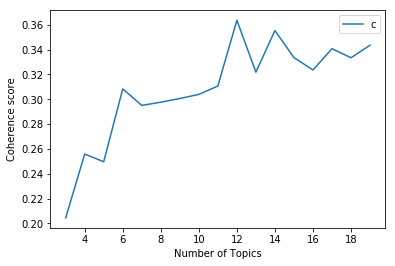

12
5973 5973
0
NUMBER OF ELEMENTS FOR THIS TOPIC 1946
Corpus length in words: 24156


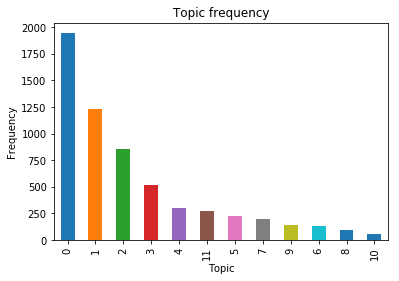

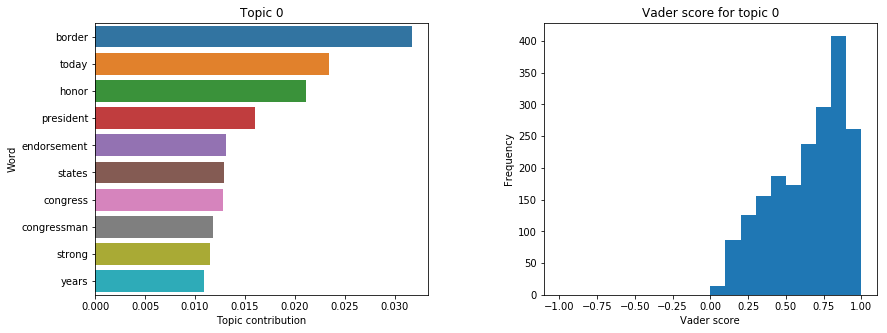

1
NUMBER OF ELEMENTS FOR THIS TOPIC 1236
Corpus length in words: 16090


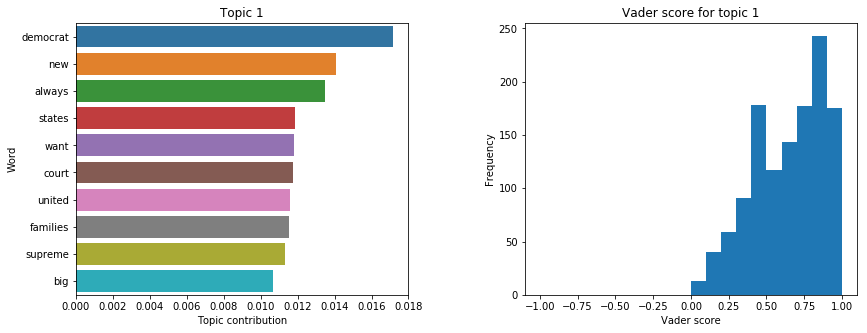

2
NUMBER OF ELEMENTS FOR THIS TOPIC 856
Corpus length in words: 11088


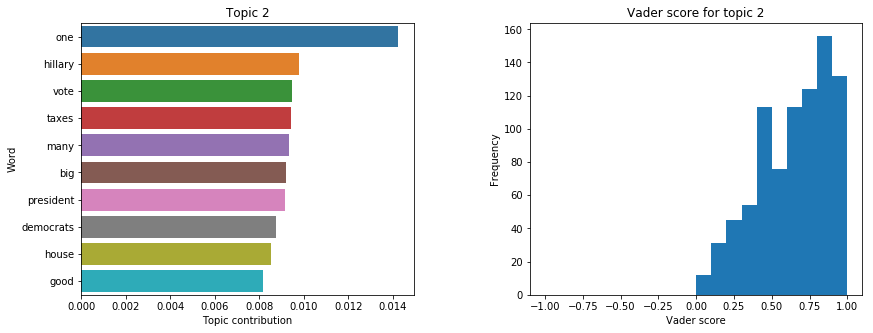

3
NUMBER OF ELEMENTS FOR THIS TOPIC 515
Corpus length in words: 6734


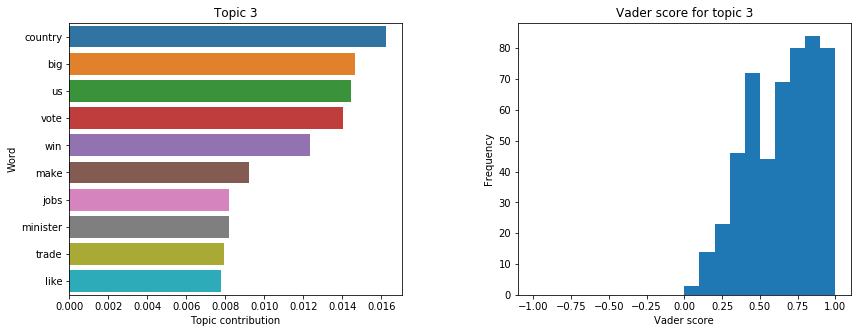

4
NUMBER OF ELEMENTS FOR THIS TOPIC 303
Corpus length in words: 3343


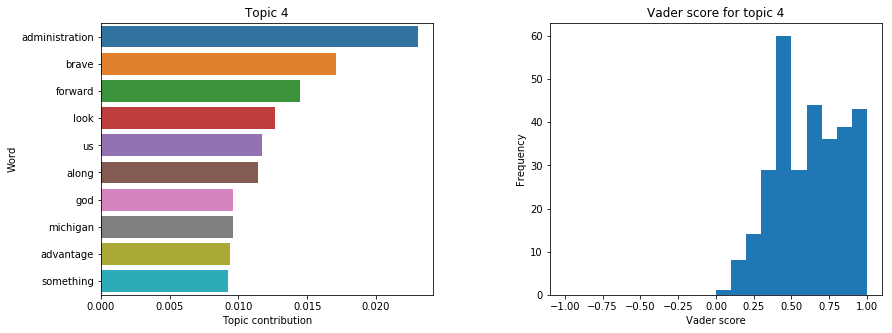

5
NUMBER OF ELEMENTS FOR THIS TOPIC 222
Corpus length in words: 1879


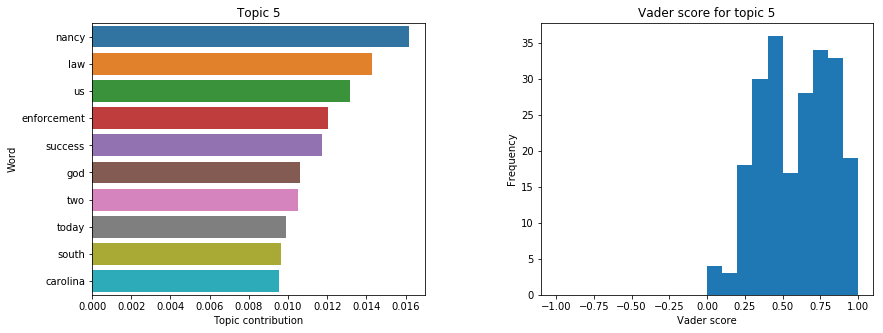

6
NUMBER OF ELEMENTS FOR THIS TOPIC 133
Corpus length in words: 772


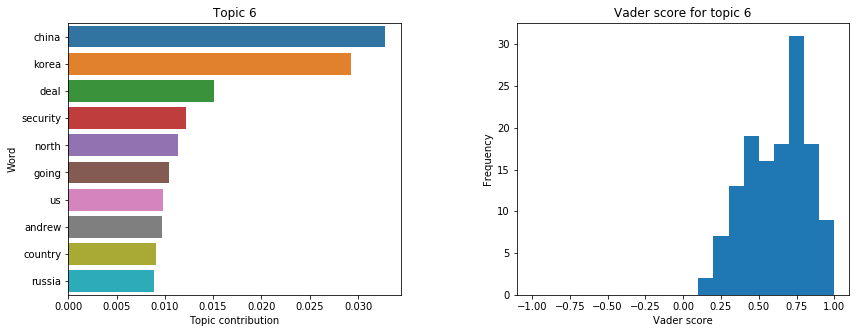

7
NUMBER OF ELEMENTS FOR THIS TOPIC 196
Corpus length in words: 876


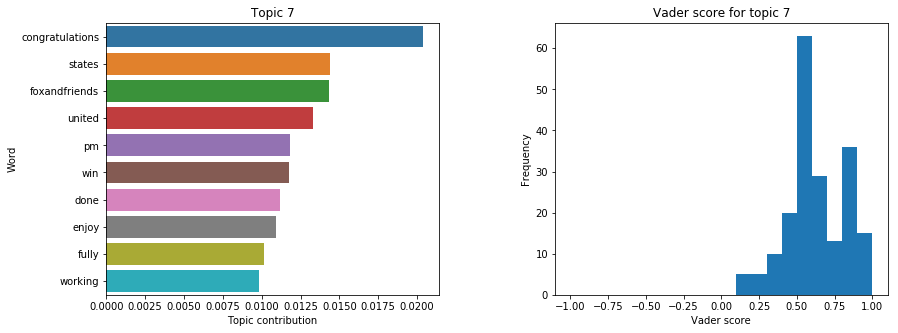

8
NUMBER OF ELEMENTS FOR THIS TOPIC 99
Corpus length in words: 483


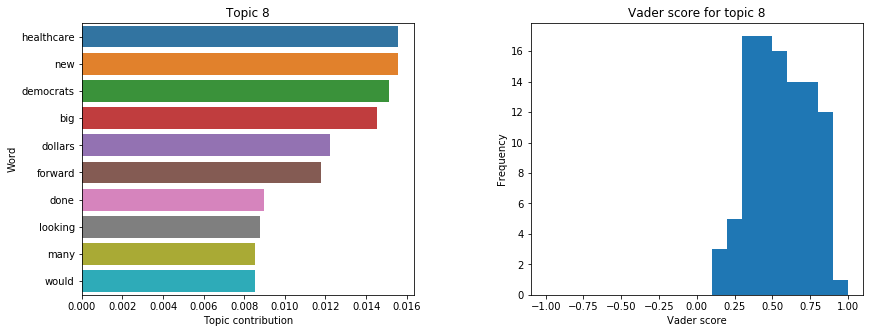

9
NUMBER OF ELEMENTS FOR THIS TOPIC 137
Corpus length in words: 616


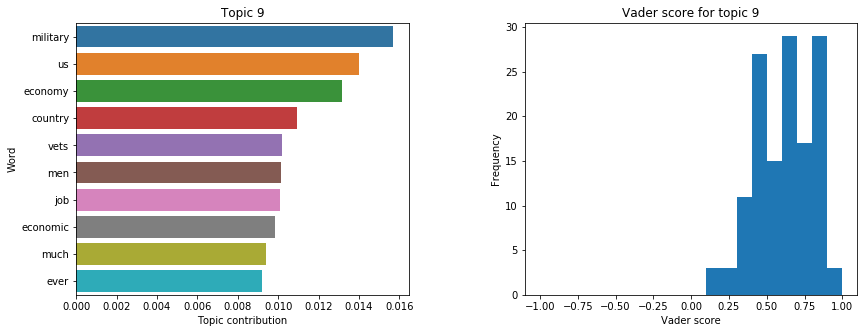

10
NUMBER OF ELEMENTS FOR THIS TOPIC 54
Corpus length in words: 262


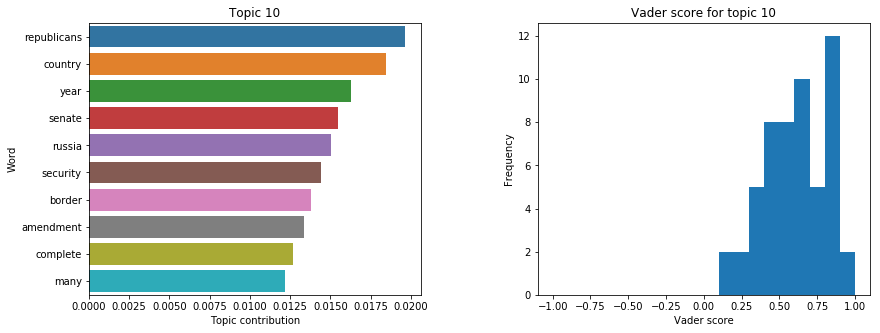

11
NUMBER OF ELEMENTS FOR THIS TOPIC 276
Corpus length in words: 1002


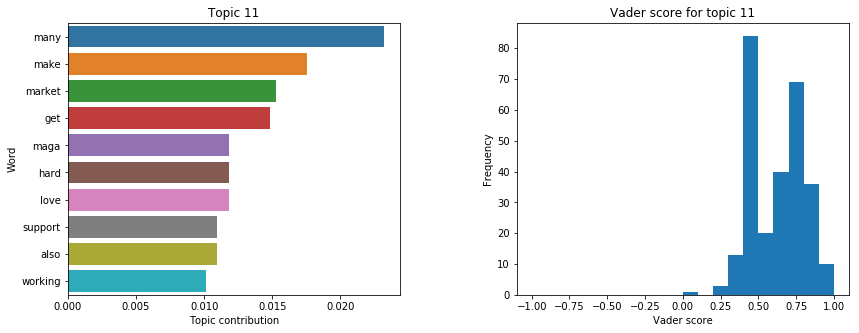

In [25]:
process(post,"positive")